# PREDICTING COASTAL FLOODS IN THE EAST VISAYAS REGION
*Gil Senecaut - 100459927*

--------------------------------------
**Structure:**
1. Data acquisition, structuring and preprocessing
2. Data imputation
3. Dimensionality reduction
4. Training regressors *(GridSearchCV for hyper-parameter and parameter tuning)*
5. Evaluate performance of top 3 *(maybe more)* models in predicting Sea Surface Height over period of time
6. Repeat previous step for period of time covering hurricane event
7. Build User Interface / Digital Twin
--------------------------------------

## 1. Data Acquisition, Structuring and Preprocessing

#### Data Structuring: ***(EDIT)***

Time | Latitude | Longitude | Precipitation Amount | Wind Direction | Wind Speed | Air Pressure | Sea Surface Height |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| *dd/mm/yy 00:00:00* | *degrees* | *degrees* | *cm* or *m* | *degrees* | *m/s* or *km/h* | *Pa*? | *m* |
| <= daily entries | dist. 16.4 | dist. 10.4 | - | 0, 45, 90 etc. or cont. | - | - | - |
| >= 1 year's worth of data | 41 0.4x0.4 squares | 26 0.4x0.4 squares | - | - | - | - | - |

In [1]:
# Imports

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from cmath import nan
import time

from attention import Attention
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
# Loading Datasets

temp_var = '/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_sst (2013-2018).nc'
temp_var = nc.Dataset(temp_var)

wind_vars = '/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_ws-ew-nw (2013-2018).nc'
wind_vars = nc.Dataset(wind_vars)

ssh_var = '/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_ssh (2017 - 2018).nc'
ssh_var = nc.Dataset(ssh_var)

#### Information on Variables

#### Convert to Dataframe + Extract X_train, y_train, etc.

In [3]:
# Convert to Numpy arrays

### Empty arrays
s = 15 # squares on the grid vertically and horizontally
s_coord = np.arange(1,s+1) 
num_wind_var = 3  # total number of wind related variables

single_year_wv = int(len(wind_vars["time"])/5)
single_year_t = int(len(temp_var["time"])/5)
single_year_ssh = int(len(ssh_var["time"])-1)

northward_wind_a = np.empty((single_year_wv,s,s), dtype=float)
eastward_wind_a = np.empty((single_year_wv,s,s), dtype=float)
wind_stress_a = np.empty((single_year_wv,s,s), dtype=float)
surface_type = np.empty((s,s), dtype=float)
temperature = np.empty((single_year_t,s,s), dtype=float)
sea_surface_height = np.empty((single_year_ssh,s,s), dtype=float)

time_steps_wv = np.empty(single_year_wv, dtype=float)
time_steps_t = np.empty(single_year_t, dtype=float)

### Northward Wind / Eastward Wind / Wind Stress
for h in range(single_year_wv):
    for i in range(num_wind_var):
        if i == 0:
            northward_wind_a[h,:,:] = wind_vars["northward_wind"][-single_year_wv+h,1:,1:]
        elif i == 1:
            eastward_wind_a[h,:,:] = wind_vars["eastward_wind"][-single_year_wv+h,1:,1:]
        elif i == 2:
            wind_stress_a[h,:,:] = wind_vars["wind_stress"][-single_year_wv+h,1:,1:]

northward_wind = np.empty((int(single_year_wv/4), s, s), dtype=float)
eastward_wind = np.empty((int(single_year_wv/4), s, s), dtype=float)
wind_stress = np.empty((int(single_year_wv/4), s, s), dtype=float)
for i in range(int(single_year_wv/4)):
    for j in range(s):
        for k in range(s):
            northward_wind[i,j,k] = np.mean(northward_wind_a[4*i:4*(i+1),j,k])
            eastward_wind[i,j,k] = np.mean(eastward_wind_a[4*i:4*(i+1),j,k])
            wind_stress[i,j,k] = np.mean(wind_stress_a[4*i:4*(i+1),j,k])

### Surface Type
for i in range(s):
    for j in range(s):
            surface_type[i,j] = wind_vars["surface_type"][0,i+1,j+1]
surface_type = surface_type.astype(int)

### Temperature
for i in range(single_year_t):
    temperature[i,:,:] = temp_var["analysed_sst"][-single_year_t+i,:,:-1]

### Sea Surface Height
for i in range(single_year_ssh):
    sea_surface_height[i,:,:] = ssh_var["sla"][-single_year_ssh+i,:,1:]

### Air Pressure

In [4]:
# Build Dataframe

df = pd.DataFrame({'Time (s)': np.array(temp_var["time"][-365:])})

for i in range(5):
    if i == 0:
        for j in range(s):
            for k in range(s):
                df['Temperature (' + str(j) + ',' + str(k) + ')'] = temperature[:,j,k]
    if i == 1:
        for j in range(s):
            for k in range(s):
                df['Northward Wind (' + str(j) + ',' + str(k) + ')'] = northward_wind[:,j,k]        
    if i == 2:
        for j in range(s):
            for k in range(s):
                df['Eastward Wind (' + str(j) + ',' + str(k) + ')'] = eastward_wind[:,j,k]
    if i == 3:
        for j in range(s):
            for k in range(s):
                df['Wind Stress (' + str(j) + ',' + str(k) + ')'] = wind_stress[:,j,k]
    if i == 4:
        for j in range(s):
            for k in range(s):
                df['Sea Surface Height (' + str(j) + ',' + str(k) + ')'] = sea_surface_height[:,j,k]

year = 365.2425*60*60*24
df['Year sin'] = np.sin(df['Time (s)'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['Time (s)'] * (2 * np.pi / year))
df = df.drop('Time (s)', axis = 1)

### Drop columns for coordinates with surface type == 1 (land)
for i in range(5):
    if i == 0:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Temperature (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)
    if i == 1:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Northward Wind (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)        
    if i == 2:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Eastward Wind (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)
    if i == 3:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Wind Stress (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)
    if i == 4:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Sea Surface Height (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)

### SSH at (4,2) all nan
df = df.drop(['Sea Surface Height (4,2)'], axis=1)
df = df.drop(['Temperature (4,2)'], axis=1)
df = df.drop(['Eastward Wind (4,2)'], axis=1)
df = df.drop(['Northward Wind (4,2)'], axis=1)
df = df.drop(['Wind Stress (4,2)'], axis=1)

df = df.copy()

C:\Users\GILSEN~1\AppData\Local\Temp/ipykernel_8548/2293974140.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Temperature (' + str(j) + ',' + str(k) + ')'] = temperature[:,j,k]
C:\Users\GILSEN~1\AppData\Local\Temp/ipykernel_8548/2293974140.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Northward Wind (' + str(j) + ',' + str(k) + ')'] = northward_wind[:,j,k]
C:\Users\GILSEN~1\AppData\Local\Temp/ipykernel_8548/2293974140.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [5]:
df.head()

,"Temperature (0,2)","Temperature (0,3)","Temperature (0,4)","Temperature (0,5)","Temperature (0,7)","Temperature (0,8)","Temperature (0,9)","Temperature (0,10)","Temperature (0,11)","Temperature (0,12)",...,"Sea Surface Height (14,7)","Sea Surface Height (14,8)","Sea Surface Height (14,9)","Sea Surface Height (14,10)","Sea Surface Height (14,11)","Sea Surface Height (14,12)","Sea Surface Height (14,13)","Sea Surface Height (14,14)",Year sin,Year cos
0,301.419983,301.380005,301.299988,301.190002,301.369995,301.559998,301.759979,302.009979,302.130005,302.149994,...,-0.2507,-0.2418,-0.2396,-0.2366,-0.2305,-0.2230,-0.2155,-0.2103,0.030444,0.999536
1,301.539978,301.479980,301.369995,301.259979,301.559998,301.750000,301.899994,302.089996,302.209991,302.269989,...,-0.2388,-0.2359,-0.2306,-0.2248,-0.2137,-0.2053,-0.2003,-0.1984,0.047634,0.998865
2,301.459991,301.389984,301.269989,301.169983,301.479980,301.729980,301.899994,302.079987,302.190002,302.220001,...,-0.2312,-0.2226,-0.2193,-0.2156,-0.2092,-0.1998,-0.1899,-0.1775,0.064809,0.997898
3,301.410004,301.320007,301.160004,301.029999,301.320007,301.559998,301.720001,301.899994,302.009979,302.049988,...,-0.2150,-0.2146,-0.2134,-0.2127,-0.2048,-0.1948,-0.1789,-0.1625,0.081965,0.996635
4,301.220001,301.139984,300.979980,300.850006,301.070007,301.320007,301.500000,301.690002,301.820007,301.880005,...,-0.2080,-0.2102,-0.2092,-0.2051,-0.1952,-0.1819,-0.1637,-0.1469,0.099097,0.995078


In [6]:
ellip = np.empty(365, dtype=str)
for i in range(len(ellip)):
    ellip = '...'

df_display = pd.DataFrame({'Temperature (0,2)': df['Temperature (0,2)'],
                           'Temperature (0,3)': df['Temperature (0,3)'],
                           '...': ellip,
                           'Sea Surface Height (14,14)': df['Sea Surface Height (14,14)'],
                           'Year sin': df['Year sin'],
                           'Year cos': df['Year cos']})

df_display.head()


,"Temperature (0,2)","Temperature (0,3)",...,"Sea Surface Height (14,14)",Year sin,Year cos
0,301.419983,301.380005,...,-0.2103,0.030444,0.999536
1,301.539978,301.479980,...,-0.1984,0.047634,0.998865
2,301.459991,301.389984,...,-0.1775,0.064809,0.997898
3,301.410004,301.320007,...,-0.1625,0.081965,0.996635
4,301.220001,301.139984,...,-0.1469,0.099097,0.995078


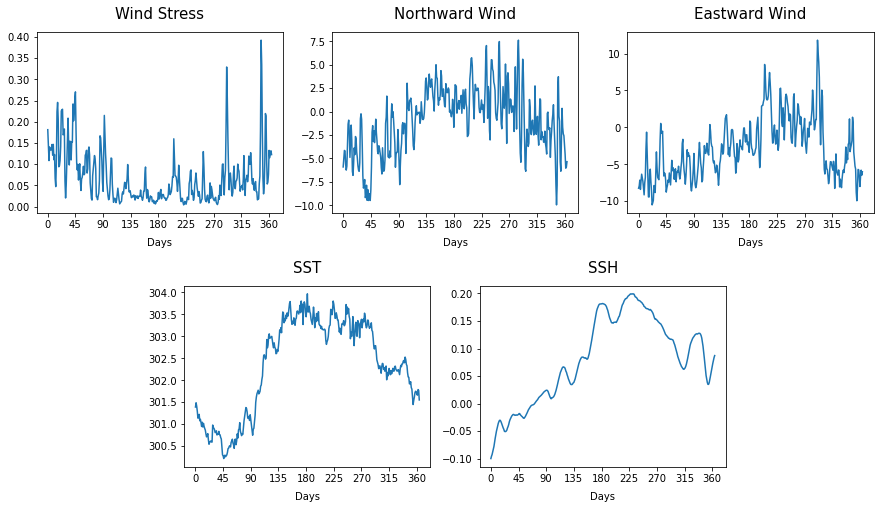

In [7]:
# Mean Variable Plots

mean_temp = []
mean_nw = []
mean_ew = []
mean_ws = []
mean_ssh = []

for i in range(len(df)):
    mean_temp.append(np.mean(df.to_numpy()[i][0:187]))
    mean_nw.append(np.mean(df.to_numpy()[i][187:187*2]))
    mean_ew.append(np.mean(df.to_numpy()[i][187*2:187*3]))
    mean_ws.append(np.mean(df.to_numpy()[i][187*3:187*4]))
    mean_ssh.append(np.mean(df.to_numpy()[i][187*4:187*5]))

fig = plt.figure(figsize=(15,8))
gs = GridSpec(2,6) 

ax0 = plt.subplot(gs[1,1:3])
ax1 = plt.subplot(gs[0,0:2])
ax2 = plt.subplot(gs[0,2:4])
ax3 = plt.subplot(gs[0,4:6])
ax4 = plt.subplot(gs[1,3:5])

ax0.plot(mean_temp)
ax0.set_title("SST", {'fontsize': 15}, pad = 13)
ax0.set_xlabel("Days", loc = "center", labelpad = 8)
ax0.set_xticks(np.arange(0,361,45))
ax1.plot(mean_ws)
ax1.set_title("Wind Stress", {'fontsize': 15}, pad = 13)
ax1.set_xlabel("Days", loc = "center", labelpad = 8)
ax1.set_xticks(np.arange(0,361,45))
ax2.plot(mean_nw)
ax2.set_title("Northward Wind", {'fontsize': 15}, pad = 13)
ax2.set_xlabel("Days", loc = "center", labelpad = 8)
ax2.set_xticks(np.arange(0,361,45))
ax3.plot(mean_ew)       
ax3.set_title("Eastward Wind", {'fontsize': 15}, pad = 13)
ax3.set_xlabel("Days", loc = "center", labelpad = 8)
ax3.set_xticks(np.arange(0,361,45))
ax4.plot(mean_ssh)                     
ax4.set_title("SSH", {'fontsize': 15}, pad = 13)
ax4.set_xlabel("Days", loc = "center", labelpad = 8)
ax4.set_xticks(np.arange(0,361,45))

gs.update(wspace=0.5, hspace=0.4)

plt.show()

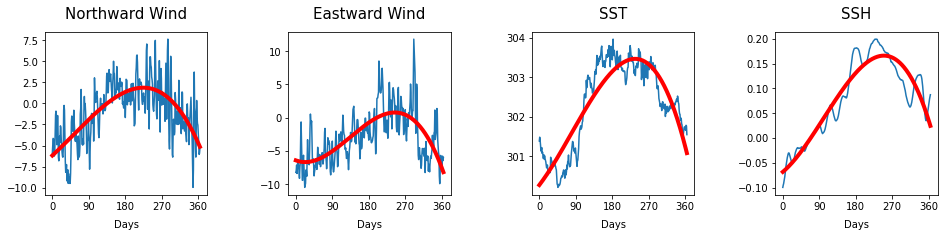

In [8]:
from turtle import color


fig = plt.figure(figsize=(16,3))
gs = GridSpec(1,4) 

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[0,3])

x = np.arange(0,365,1)

ax2.plot(mean_temp)
z = np.polyfit(x, mean_temp, 3)
p = np.poly1d(z)
ax2.plot(x, p(x), linewidth=4, color='red') 
ax2.set_title("SST", {'fontsize': 15}, pad = 13)
ax2.set_xlabel("Days", loc = "center", labelpad = 8)
ax2.set_xticks(np.arange(0,361,90))

ax0.plot(mean_nw)
z = np.polyfit(x, mean_nw, 3)
p = np.poly1d(z)
ax0.plot(x, p(x), linewidth=4, color='red')
ax0.set_title("Northward Wind", {'fontsize': 15}, pad = 13)
ax0.set_xlabel("Days", loc = "center", labelpad = 8)
ax0.set_xticks(np.arange(0,361,90))

ax1.plot(mean_ew)
z = np.polyfit(x, mean_ew, 3)
p = np.poly1d(z)
ax1.plot(x, p(x), linewidth=4, color='red')    
ax1.set_title("Eastward Wind", {'fontsize': 15}, pad = 13)
ax1.set_xlabel("Days", loc = "center", labelpad = 8)
ax1.set_xticks(np.arange(0,361,90))

ax3.plot(mean_ssh)
z = np.polyfit(x, mean_ssh, 3)
p = np.poly1d(z)
ax3.plot(x, p(x), linewidth=4, color='red')                      
ax3.set_title("SSH", {'fontsize': 15}, pad = 13)
ax3.set_xlabel("Days", loc = "center", labelpad = 8)
ax3.set_xticks(np.arange(0,361,90))

gs.update(wspace=0.5, hspace=0.4)

plt.show()

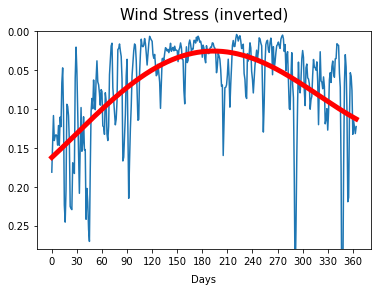

In [9]:
x = np.arange(0,365,1)
y = mean_ws

plt.plot(x,y)
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
plt.plot(x, p(x), linewidth=5, color='red')
plt.ylim(0,0.28)
plt.title("Wind Stress (inverted)", {'fontsize': 15}, pad = 13)
plt.xlabel("Days", loc = "center", labelpad = 8)
plt.xticks(np.arange(0,361,30))
plt.gca().invert_yaxis()

In [10]:
# Extract X and y
window_size = 7

def df_to_X_y(df, window_size=window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X1, y1 = df_to_X_y(df)
print('X shape = ' + str(X1.shape) + ' and y shape = ' + str(y1.shape))

X shape = (358, 7, 937) and y shape = (358, 187)


In [11]:
X = np.empty((5,4,3), dtype=object)

for i in range(5):
    for j in range(3):
        for k in range(2):
            X[i,j,k] = round(X1[i,j,k],2)

for i in range(5):
    X[i,3,:] = '...'

for i in range(5):
    X[i,:,2] = '...'

y = np.empty((5,3), dtype = object)
for i in range(5):
    y[i,0] = round(y1[i,0],4)
    y[i,1] = round(y1[i,1],4)
    y[i,2] = '...'

print('['+ str(X[0,:,:].tolist()[0]) + ', ' + str(X[0,:,:].tolist()[1]) + ', ' + str(X[0,:,:].tolist()[3]) + '] = ' + str(y[0,:].tolist()))
print('['+ str(X[1,:,:].tolist()[0]) + ', ' + str(X[1,:,:].tolist()[1]) + ', ' + str(X[1,:,:].tolist()[3]) + '] = ' + str(y[1,:].tolist()))
print('['+ str(X[2,:,:].tolist()[0]) + ', ' + str(X[2,:,:].tolist()[1]) + ', ' + str(X[2,:,:].tolist()[3]) + '] = ' + str(y[2,:].tolist()))
print('['+ str(X[3,:,:].tolist()[0]) + ', ' + str(X[3,:,:].tolist()[1]) + ', ' + str(X[3,:,:].tolist()[3]) + '] = ' + str(y[3,:].tolist()))
print('['+ str(X[4,:,:].tolist()[0]) + ', ' + str(X[4,:,:].tolist()[1]) + ', ' + str(X[4,:,:].tolist()[3]) + '] = ' + str(y[4,:].tolist()))



[[301.42, 301.38, '...'], [301.54, 301.48, '...'], ['...', '...', '...']] = [-0.0271, -0.0147, '...']
[[301.54, 301.48, '...'], [301.46, 301.39, '...'], ['...', '...', '...']] = [-0.0192, -0.0048, '...']
[[301.46, 301.39, '...'], [301.41, 301.32, '...'], ['...', '...', '...']] = [-0.0105, 0.0063, '...']
[[301.41, 301.32, '...'], [301.22, 301.14, '...'], ['...', '...', '...']] = [-0.0049, 0.0087, '...']
[[301.22, 301.14, '...'], [301.15, 301.09, '...'], ['...', '...', '...']] = [-0.0004, 0.0075, '...']


In [12]:
# Divide into train, validate and test
days = np.shape(X1)[0]
lfw = days-28 # days before the last two weeks
lew = days-56 # days before the last six

X1_train, y1_train = X1[:lew], y1[:lew]
X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
X1_test, y1_test = X1[lfw:], y1[lfw:]

print('X_train shape = ' + str(X1_train.shape))
print('y_train shape = ' + str(y1_train.shape))
print('X_val shape = ' + str(X1_val.shape))
print('y_val shape = ' + str(y1_val.shape))
print('X_test shape = ' + str(X1_test.shape))
print('y_test shape = ' + str(y1_test.shape))


X_train shape = (302, 7, 937)
y_train shape = (302, 187)
X_val shape = (28, 7, 937)
y_val shape = (28, 187)
X_test shape = (28, 7, 937)
y_test shape = (28, 187)


#### Preprocessing

In [13]:
# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
    east_training_std[i] = np.std(X1_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X1_train[:, :, i+187])
    north_training_std[i] = np.std(X1_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X1_train[:, :, i])
    temp_training_std[i] = np.std(X1_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X1_train, y1_train)
preprocess(X1_val, y1_val)
preprocess(X1_test, y1_test)

In [14]:
### Imputation?

# with ssh at coordinates (4,2) being all nan, probably worth trying imputation with mean of ssh at neighbouring grids.
# if enough time, worth trying different imputation methods and calculating accuracy of different imputation methods. 

In [15]:
### Dimentionality reduction?

## 2. Training, Testing and Comparing Algorithms

### 2.0. Setup

In [16]:
import math
def round_decimals_down(number:float, decimals:int=1):
   
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor
def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

In [17]:
def plot_predictions(model, X, y):
  predictions = model.predict(X).flatten()
  MSE = mse(y.flatten(), predictions)
  RMSE = np.sqrt(MSE)
  MAE = mae(y.flatten(), predictions)

  print('MSE = ', str(MSE))
  print('RMSE = ', str(RMSE))
  print('MAE = ', str(MAE))


  fig = plt.figure(figsize=(16,7))
  gs = GridSpec(2,4)

  ax0 = plt.subplot(gs[0,0])
  ax1 = plt.subplot(gs[0,1])
  ax2 = plt.subplot(gs[0,2])
  ax3 = plt.subplot(gs[0,3])
  ax4 = plt.subplot(gs[1,0])
  ax5 = plt.subplot(gs[1,1])
  ax6 = plt.subplot(gs[1,2])
  ax7 = plt.subplot(gs[1,3])

  dfs = np.empty(8, dtype= object)
  mins = np.empty(8, dtype= object)
  maxs = np.empty(8, dtype= object)
  for i in range(8):
    dfs[i] = pd.DataFrame(data={'Predictions':predictions[i::187], 'Actuals':y[:,i]})
    mins[i] = np.min(dfs[i].to_numpy())
    maxs[i] = np.max(dfs[i].to_numpy())

  u = round_decimals_up(np.max(maxs))+0.1
  d = round_decimals_down(np.min(mins))-0.1

  ax0.plot(dfs[0]['Predictions'][:])
  ax0.plot(dfs[0]['Actuals'][:])
  ax0.set_title("Grid"+str(1), {'fontsize': 12}, pad = 10)
  ax0.set_xlabel("Days", loc = "left", labelpad = 5)
  ax0.set_xticks(np.arange(0,29,7))
  ax0.set_ybound(d, u)
  ax1.plot(dfs[1]['Predictions'][:])
  ax1.plot(dfs[1]['Actuals'][:])
  ax1.set_title("Grid"+str(2), {'fontsize': 12}, pad = 10)
  ax1.set_xlabel("Days", loc = "left", labelpad = 5)
  ax1.set_xticks(np.arange(0,29,7))
  ax1.set_ybound(d, u)
  ax2.plot(dfs[2]['Predictions'][:])
  ax2.plot(dfs[2]['Actuals'][:])
  ax2.set_title("Grid"+str(3), {'fontsize': 12}, pad = 10)
  ax2.set_xlabel("Days", loc = "left", labelpad = 5)
  ax2.set_xticks(np.arange(0,29,7))
  ax2.set_ybound(d, u)
  ax3.plot(dfs[3]['Predictions'][:])
  ax3.plot(dfs[3]['Actuals'][:])
  ax3.set_title("Grid"+str(4), {'fontsize': 12}, pad = 10)
  ax3.set_xlabel("Days", loc = "left", labelpad = 5)
  ax3.set_xticks(np.arange(0,29,7))
  ax3.set_ybound(d, u)
  ax4.plot(dfs[4]['Predictions'][:])
  ax4.plot(dfs[4]['Actuals'][:])
  ax4.set_title("Grid"+str(5), {'fontsize': 12}, pad = 10)
  ax4.set_xlabel("Days", loc = "left", labelpad = 5)
  ax4.set_xticks(np.arange(0,29,7))
  ax4.set_ybound(d, u)
  ax5.plot(dfs[5]['Predictions'][:])
  ax5.plot(dfs[5]['Actuals'][:])
  ax5.set_title("Grid"+str(6), {'fontsize': 12}, pad = 10)
  ax5.set_xlabel("Days", loc = "left", labelpad = 5)
  ax5.set_xticks(np.arange(0,29,7))
  ax5.set_ybound(d, u)
  ax6.plot(dfs[6]['Predictions'][:])
  ax6.plot(dfs[6]['Actuals'][:])
  ax6.set_title("Grid"+str(7), {'fontsize': 12}, pad = 10)
  ax6.set_xlabel("Days", loc = "left", labelpad = 5)
  ax6.set_xticks(np.arange(0,29,7))
  ax6.set_ybound(d, u)
  ax7.plot(dfs[7]['Predictions'][:])
  ax7.plot(dfs[7]['Actuals'][:])
  ax7.set_title("Grid"+str(8), {'fontsize': 12}, pad = 10)
  ax7.set_xlabel("Days", loc = "left", labelpad = 5)
  ax7.set_xticks(np.arange(0,29,7))
  ax7.set_ybound(d, u)

  gs.update(wspace=0.3, hspace=0.4)

In [18]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

### 2.1. Training and Testing

##### **LSTM** *with window size = 7 and number of epochs = 50*

In [ ]:
vlstm_model_ws7_e50 = Sequential()
vlstm_model_ws7_e50.add(InputLayer((window_size, 937)))
vlstm_model_ws7_e50.add(LSTM(640))
vlstm_model_ws7_e50.add(Dense(320, 'relu'))
vlstm_model_ws7_e50.add(Dense(187, 'linear'))

vlstm_model_ws7_e50.summary()

Model: "sequential_189"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_127 (LSTM)             (None, 640)               4039680   
                                                                 
 dense_754 (Dense)           (None, 320)               205120    
                                                                 
 dense_755 (Dense)           (None, 187)               60027     
                                                                 
Total params: 4,304,827
Trainable params: 4,304,827
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('vlstm_model_ws7_e50/', save_best_only=True)
lh1 = LossHistory()
vlstm_model_ws7_e50.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
vlstm_model_ws7_e50.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=50, callbacks=[cp1, lh1])
vlstm_model_ws7_e50 = load_model('vlstm_model_ws7_e50/')

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.5174 - root_mean_squared_error: 0.7193

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 33s 3s/step - loss: 0.5174 - root_mean_squared_error: 0.7193 - val_loss: 0.5658 - val_root_mean_squared_error: 0.7522
Epoch 2/50
10/10 [==============================] - 15s 2s/step - loss: 0.3471 - root_mean_squared_error: 0.5892 - val_loss: 0.5817 - val_root_mean_squared_error: 0.7627
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.2446 - root_mean_squared_error: 0.4946

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 37s 4s/step - loss: 0.2446 - root_mean_squared_error: 0.4946 - val_loss: 0.5540 - val_root_mean_squared_error: 0.7443
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.1776 - root_mean_squared_error: 0.4214

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.1776 - root_mean_squared_error: 0.4214 - val_loss: 0.4906 - val_root_mean_squared_error: 0.7004
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 0.1334 - root_mean_squared_error: 0.3653

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.1334 - root_mean_squared_error: 0.3653 - val_loss: 0.4512 - val_root_mean_squared_error: 0.6717
Epoch 6/50
10/10 [==============================] - ETA: 0s - loss: 0.1071 - root_mean_squared_error: 0.3272

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.1071 - root_mean_squared_error: 0.3272 - val_loss: 0.4199 - val_root_mean_squared_error: 0.6480
Epoch 7/50
10/10 [==============================] - ETA: 0s - loss: 0.0897 - root_mean_squared_error: 0.2995

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0897 - root_mean_squared_error: 0.2995 - val_loss: 0.3980 - val_root_mean_squared_error: 0.6309
Epoch 8/50
10/10 [==============================] - ETA: 0s - loss: 0.0772 - root_mean_squared_error: 0.2778

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0772 - root_mean_squared_error: 0.2778 - val_loss: 0.3857 - val_root_mean_squared_error: 0.6211
Epoch 9/50
10/10 [==============================] - ETA: 0s - loss: 0.0671 - root_mean_squared_error: 0.2591

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0671 - root_mean_squared_error: 0.2591 - val_loss: 0.3787 - val_root_mean_squared_error: 0.6154
Epoch 10/50
10/10 [==============================] - ETA: 0s - loss: 0.0587 - root_mean_squared_error: 0.2423

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0587 - root_mean_squared_error: 0.2423 - val_loss: 0.3667 - val_root_mean_squared_error: 0.6056
Epoch 11/50
10/10 [==============================] - ETA: 0s - loss: 0.0521 - root_mean_squared_error: 0.2283

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0521 - root_mean_squared_error: 0.2283 - val_loss: 0.3584 - val_root_mean_squared_error: 0.5987
Epoch 12/50
10/10 [==============================] - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.2159

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.3516 - val_root_mean_squared_error: 0.5929
Epoch 13/50
10/10 [==============================] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.2045

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.3441 - val_root_mean_squared_error: 0.5866
Epoch 14/50
10/10 [==============================] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1961

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0385 - root_mean_squared_error: 0.1961 - val_loss: 0.3402 - val_root_mean_squared_error: 0.5833
Epoch 15/50
10/10 [==============================] - ETA: 0s - loss: 0.0351 - root_mean_squared_error: 0.1874

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0351 - root_mean_squared_error: 0.1874 - val_loss: 0.3326 - val_root_mean_squared_error: 0.5767
Epoch 16/50
10/10 [==============================] - ETA: 0s - loss: 0.0321 - root_mean_squared_error: 0.1792

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0321 - root_mean_squared_error: 0.1792 - val_loss: 0.3291 - val_root_mean_squared_error: 0.5736
Epoch 17/50
10/10 [==============================] - ETA: 0s - loss: 0.0295 - root_mean_squared_error: 0.1717

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.3172 - val_root_mean_squared_error: 0.5632
Epoch 18/50
10/10 [==============================] - ETA: 0s - loss: 0.0274 - root_mean_squared_error: 0.1654

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0274 - root_mean_squared_error: 0.1654 - val_loss: 0.3108 - val_root_mean_squared_error: 0.5575
Epoch 19/50
10/10 [==============================] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.1596

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0255 - root_mean_squared_error: 0.1596 - val_loss: 0.3066 - val_root_mean_squared_error: 0.5537
Epoch 20/50
10/10 [==============================] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.1539

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.3041 - val_root_mean_squared_error: 0.5514
Epoch 21/50
10/10 [==============================] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.1487

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 0.2999 - val_root_mean_squared_error: 0.5476
Epoch 22/50
10/10 [==============================] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.1441

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.2978 - val_root_mean_squared_error: 0.5457
Epoch 23/50
10/10 [==============================] - ETA: 0s - loss: 0.0193 - root_mean_squared_error: 0.1389

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.2955 - val_root_mean_squared_error: 0.5436
Epoch 24/50
10/10 [==============================] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.1343

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 26s 3s/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.2867 - val_root_mean_squared_error: 0.5355
Epoch 25/50
10/10 [==============================] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.1305

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.2838 - val_root_mean_squared_error: 0.5327
Epoch 26/50
10/10 [==============================] - ETA: 0s - loss: 0.0159 - root_mean_squared_error: 0.1261

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.2810 - val_root_mean_squared_error: 0.5301
Epoch 27/50
10/10 [==============================] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1229

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.2788 - val_root_mean_squared_error: 0.5280
Epoch 28/50
10/10 [==============================] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1187

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.2743 - val_root_mean_squared_error: 0.5237
Epoch 29/50
10/10 [==============================] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1152

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.2732 - val_root_mean_squared_error: 0.5227
Epoch 30/50
10/10 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.1120

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.2704 - val_root_mean_squared_error: 0.5200
Epoch 31/50
10/10 [==============================] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.1094

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.2660 - val_root_mean_squared_error: 0.5157
Epoch 32/50
10/10 [==============================] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1066

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.2658 - val_root_mean_squared_error: 0.5156
Epoch 33/50
10/10 [==============================] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.1039

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.2644 - val_root_mean_squared_error: 0.5142
Epoch 34/50
10/10 [==============================] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1016

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.2621 - val_root_mean_squared_error: 0.5120
Epoch 35/50
10/10 [==============================] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0988

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.2580 - val_root_mean_squared_error: 0.5079
Epoch 36/50
10/10 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0963

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.2563 - val_root_mean_squared_error: 0.5062
Epoch 37/50
10/10 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0951

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 24s 2s/step - loss: 0.0090 - root_mean_squared_error: 0.0951 - val_loss: 0.2517 - val_root_mean_squared_error: 0.5017
Epoch 38/50
10/10 [==============================] - 16s 2s/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.2520 - val_root_mean_squared_error: 0.5020
Epoch 39/50
10/10 [==============================] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0909

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.2505 - val_root_mean_squared_error: 0.5005
Epoch 40/50
10/10 [==============================] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0893

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.2491 - val_root_mean_squared_error: 0.4991
Epoch 41/50
10/10 [==============================] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0869

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 28s 3s/step - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.2463 - val_root_mean_squared_error: 0.4963
Epoch 42/50
10/10 [==============================] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0852

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.2440 - val_root_mean_squared_error: 0.4940
Epoch 43/50
10/10 [==============================] - 13s 1s/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.2442 - val_root_mean_squared_error: 0.4941
Epoch 44/50
10/10 [==============================] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0819

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


10/10 [==============================] - 24s 3s/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.2432 - val_root_mean_squared_error: 0.4932
Epoch 45/50
10/10 [==============================] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0811

KeyboardInterrupt: 

MSE =  0.35926174967965513
RMSE =  0.5993844756745499
MAE =  0.48216168707585644


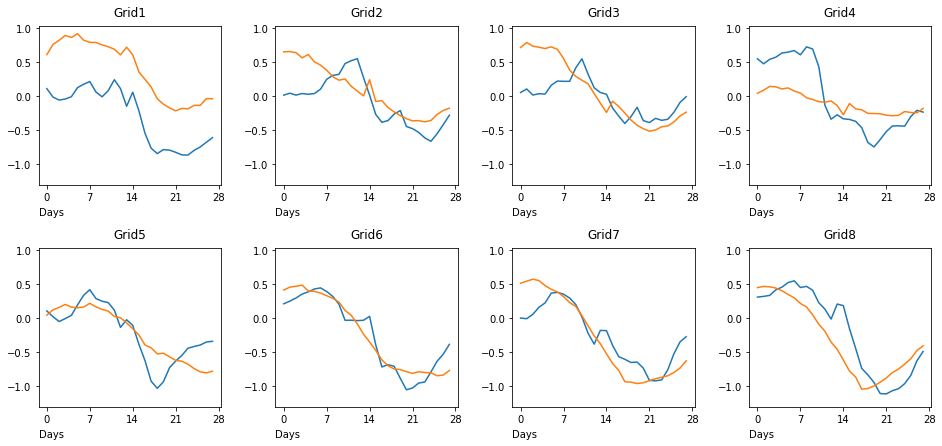

In [ ]:
# Evaluate Vanilla LSTM

plot_predictions(vlstm_model_ws7_e50, X1_test, y1_test)

Determine optimal number of epochs

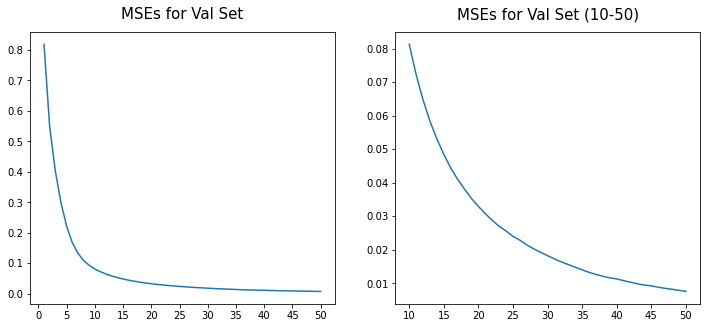

In [ ]:
ax0_xlab = [str(n) for n in np.arange(1,52,5)-1]
ax1_xlab = [str(n) for n in np.arange(11,52,5)-1]
losses = [nan] + lh1.losses

fig = plt.figure(figsize=(12,5))
gs = GridSpec(1,2) 

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.plot(losses)
ax0.set_xticks(np.arange(0,51,5).tolist());ax0.set_xticklabels(ax0_xlab)
ax0.set_title("MSEs for Val Set", {'fontsize': 15}, pad = 13)
ax1.plot(losses[10:])
ax1.set_xticks(np.arange(0,41,5));ax1.set_xticklabels(ax1_xlab)
ax1.set_title("MSEs for Val Set (10-50)", {'fontsize': 15}, pad = 13)

gs.update(wspace=0.2)

plt.show()

Determine optimal window size *(epochs = 25)*

In [ ]:
df_err_ws = pd.DataFrame(data={'Metrics':['MSE','RMSE','MAE','MAPE','Time (s)']})

win_sizes = np.arange(1,11)[::-1]

for ws in win_sizes:

    def df_to_X_y(df, window_size=ws):
        df_as_np = df.to_numpy()
        X = []
        y = []
        for i in range(len(df_as_np)-window_size):
          row = [r for r in df_as_np[i:i+window_size]]
          X.append(row)
          label = df_as_np[i+window_size][748:935].tolist()
          y.append(label)
        return np.array(X), np.array(y)

    X1, y1 = df_to_X_y(df)

    days = np.shape(X1)[0]
    lfw = days-28 # days before the last two weeks
    lew = days-56 # days before the last six

    X1_train, y1_train = X1[:lew], y1[:lew]
    X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
    X1_test, y1_test = X1[lfw:], y1[lfw:]

    ssh_training_mean = np.empty(187, dtype=float)
    ssh_training_std = np.empty(187, dtype=float)
    stress_training_mean = np.empty(187, dtype=float)
    stress_training_std = np.empty(187, dtype=float)
    east_training_mean = np.empty(187, dtype=float)
    east_training_std = np.empty(187, dtype=float)
    north_training_mean = np.empty(187, dtype=float)
    north_training_std = np.empty(187, dtype=float)
    temp_training_mean = np.empty(187, dtype=float)
    temp_training_std = np.empty(187, dtype=float)
    
    for i in range(187):
        ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
        ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
        stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
        stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
        east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
        east_training_std[i] = np.std(X1_train[:, :, i+2*187])
        north_training_mean[i] = np.mean(X1_train[:, :, i+187])
        north_training_std[i] = np.std(X1_train[:, :, i+187])
        temp_training_mean[i] = np.mean(X1_train[:, :, i])
        temp_training_std[i] = np.std(X1_train[:, :, i])
    
    def preprocess(X,y):
      for i in range(187):
        X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
        X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
        X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
        X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
        X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]
    
        y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]
    
    preprocess(X1_train, y1_train)
    preprocess(X1_val, y1_val)
    preprocess(X1_test, y1_test)

    start = time.time()

    vlstm_model = Sequential()
    vlstm_model.add(InputLayer((ws, 937)))
    vlstm_model.add(LSTM(640))
    vlstm_model.add(Dense(320, 'relu'))
    vlstm_model.add(Dense(187, 'linear'))

    cp1 = ModelCheckpoint('vlstm_model/', save_best_only=True)
    vlstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    vlstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp1])
    vlstm_model = load_model('vlstm_model/')

    end = time.time()

    predictions = vlstm_model.predict(X1_test).flatten()
    df_err_ws['Win Size ' + str(ws)] = [mse(y1_test.flatten(), predictions),
                                        np.sqrt(mse(y1_test.flatten(), predictions)),
                                        mae(y1_test.flatten(), predictions),
                                        mape(y1_test.flatten(), predictions),
                                        end-start]

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7640 - root_mean_squared_error: 0.8741

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 630ms/step - loss: 0.7640 - root_mean_squared_error: 0.8741 - val_loss: 0.5211 - val_root_mean_squared_error: 0.7219
Epoch 2/25
10/10 [==============================] - 2s 193ms/step - loss: 0.4882 - root_mean_squared_error: 0.6987 - val_loss: 0.6516 - val_root_mean_squared_error: 0.8072
Epoch 3/25
10/10 [==============================] - 2s 170ms/step - loss: 0.3494 - root_mean_squared_error: 0.5911 - val_loss: 0.6948 - val_root_mean_squared_error: 0.8336
Epoch 4/25
10/10 [==============================] - 2s 164ms/step - loss: 0.2519 - root_mean_squared_error: 0.5019 - val_loss: 0.6926 - val_root_mean_squared_error: 0.8322
Epoch 5/25
10/10 [==============================] - 2s 167ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322 - val_loss: 0.6571 - val_root_mean_squared_error: 0.8106
Epoch 6/25
10/10 [==============================] - 2s 168ms/step - loss: 0.1454 - root_mean_squared_error: 0.3813 - val_loss: 0.6252 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 657ms/step - loss: 0.0749 - root_mean_squared_error: 0.2737 - val_loss: 0.5200 - val_root_mean_squared_error: 0.7211
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0660 - root_mean_squared_error: 0.2570

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 594ms/step - loss: 0.0660 - root_mean_squared_error: 0.2570 - val_loss: 0.5045 - val_root_mean_squared_error: 0.7103
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0590 - root_mean_squared_error: 0.2428

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 656ms/step - loss: 0.0590 - root_mean_squared_error: 0.2428 - val_loss: 0.4922 - val_root_mean_squared_error: 0.7016
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0529 - root_mean_squared_error: 0.2300

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 705ms/step - loss: 0.0529 - root_mean_squared_error: 0.2300 - val_loss: 0.4787 - val_root_mean_squared_error: 0.6919
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.2187

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 602ms/step - loss: 0.0478 - root_mean_squared_error: 0.2187 - val_loss: 0.4726 - val_root_mean_squared_error: 0.6874
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.2084

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 583ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_loss: 0.4669 - val_root_mean_squared_error: 0.6833
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0398 - root_mean_squared_error: 0.1995

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 581ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995 - val_loss: 0.4630 - val_root_mean_squared_error: 0.6804
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0367 - root_mean_squared_error: 0.1915

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 514ms/step - loss: 0.0367 - root_mean_squared_error: 0.1915 - val_loss: 0.4570 - val_root_mean_squared_error: 0.6760
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0340 - root_mean_squared_error: 0.1843

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 637ms/step - loss: 0.0340 - root_mean_squared_error: 0.1843 - val_loss: 0.4527 - val_root_mean_squared_error: 0.6729
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1777

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 576ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - val_loss: 0.4464 - val_root_mean_squared_error: 0.6682
Epoch 20/25
10/10 [==============================] - 2s 180ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711 - val_loss: 0.4467 - val_root_mean_squared_error: 0.6683
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0274 - root_mean_squared_error: 0.1656

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 543ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.4459 - val_root_mean_squared_error: 0.6678
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.1597

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 511ms/step - loss: 0.0255 - root_mean_squared_error: 0.1597 - val_loss: 0.4361 - val_root_mean_squared_error: 0.6603
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0240 - root_mean_squared_error: 0.1551

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 563ms/step - loss: 0.0240 - root_mean_squared_error: 0.1551 - val_loss: 0.4321 - val_root_mean_squared_error: 0.6573
Epoch 24/25
10/10 [==============================] - 2s 178ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.4328 - val_root_mean_squared_error: 0.6579
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.1453

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 563ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.4276 - val_root_mean_squared_error: 0.6539
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8183 - root_mean_squared_error: 0.9046

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 580ms/step - loss: 0.8183 - root_mean_squared_error: 0.9046 - val_loss: 0.4308 - val_root_mean_squared_error: 0.6564
Epoch 2/25
10/10 [==============================] - 2s 184ms/step - loss: 0.5452 - root_mean_squared_error: 0.7384 - val_loss: 0.5167 - val_root_mean_squared_error: 0.7188
Epoch 3/25
10/10 [==============================] - 2s 191ms/step - loss: 0.4032 - root_mean_squared_error: 0.6350 - val_loss: 0.5860 - val_root_mean_squared_error: 0.7655
Epoch 4/25
10/10 [==============================] - 2s 175ms/step - loss: 0.2949 - root_mean_squared_error: 0.5430 - val_loss: 0.6122 - val_root_mean_squared_error: 0.7824
Epoch 5/25
10/10 [==============================] - 2s 196ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658 - val_loss: 0.6112 - val_root_mean_squared_error: 0.7818
Epoch 6/25
10/10 [==============================] - 2s 168ms/step - loss: 0.1629 - root_mean_squared_error: 0.4036 - val_loss: 0.5958 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 580ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.4208 - val_root_mean_squared_error: 0.6487
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0337 - root_mean_squared_error: 0.1837

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 631ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - val_loss: 0.4160 - val_root_mean_squared_error: 0.6450
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0315 - root_mean_squared_error: 0.1774

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 553ms/step - loss: 0.0315 - root_mean_squared_error: 0.1774 - val_loss: 0.4123 - val_root_mean_squared_error: 0.6421
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0294 - root_mean_squared_error: 0.1716

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 585ms/step - loss: 0.0294 - root_mean_squared_error: 0.1716 - val_loss: 0.4117 - val_root_mean_squared_error: 0.6417
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.1660

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 607ms/step - loss: 0.0276 - root_mean_squared_error: 0.1660 - val_loss: 0.4114 - val_root_mean_squared_error: 0.6414
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0257 - root_mean_squared_error: 0.1604

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 531ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.4066 - val_root_mean_squared_error: 0.6377
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0242 - root_mean_squared_error: 0.1556

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 513ms/step - loss: 0.0242 - root_mean_squared_error: 0.1556 - val_loss: 0.4040 - val_root_mean_squared_error: 0.6356
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0229 - root_mean_squared_error: 0.1514

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 622ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514 - val_loss: 0.3986 - val_root_mean_squared_error: 0.6313
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8096 - root_mean_squared_error: 0.8998

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 547ms/step - loss: 0.8096 - root_mean_squared_error: 0.8998 - val_loss: 0.4510 - val_root_mean_squared_error: 0.6716
Epoch 2/25
10/10 [==============================] - 2s 158ms/step - loss: 0.5411 - root_mean_squared_error: 0.7356 - val_loss: 0.5346 - val_root_mean_squared_error: 0.7312
Epoch 3/25
10/10 [==============================] - 1s 146ms/step - loss: 0.3920 - root_mean_squared_error: 0.6261 - val_loss: 0.5833 - val_root_mean_squared_error: 0.7638
Epoch 4/25
10/10 [==============================] - 1s 148ms/step - loss: 0.2835 - root_mean_squared_error: 0.5324 - val_loss: 0.6040 - val_root_mean_squared_error: 0.7772
Epoch 5/25
10/10 [==============================] - 1s 139ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553 - val_loss: 0.5918 - val_root_mean_squared_error: 0.7693
Epoch 6/25
10/10 [==============================] - 1s 152ms/step - loss: 0.1569 - root_mean_squared_error: 0.3961 - val_loss: 0.5743 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 541ms/step - loss: 0.0711 - root_mean_squared_error: 0.2666 - val_loss: 0.4448 - val_root_mean_squared_error: 0.6670
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0636 - root_mean_squared_error: 0.2521

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 570ms/step - loss: 0.0636 - root_mean_squared_error: 0.2521 - val_loss: 0.4298 - val_root_mean_squared_error: 0.6556
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0568 - root_mean_squared_error: 0.2383

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 515ms/step - loss: 0.0568 - root_mean_squared_error: 0.2383 - val_loss: 0.4162 - val_root_mean_squared_error: 0.6452
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0512 - root_mean_squared_error: 0.2264

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 553ms/step - loss: 0.0512 - root_mean_squared_error: 0.2264 - val_loss: 0.4062 - val_root_mean_squared_error: 0.6374
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.2155

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 499ms/step - loss: 0.0464 - root_mean_squared_error: 0.2155 - val_loss: 0.3991 - val_root_mean_squared_error: 0.6317
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.2060

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 538ms/step - loss: 0.0424 - root_mean_squared_error: 0.2060 - val_loss: 0.3855 - val_root_mean_squared_error: 0.6209
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0390 - root_mean_squared_error: 0.1974

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 516ms/step - loss: 0.0390 - root_mean_squared_error: 0.1974 - val_loss: 0.3782 - val_root_mean_squared_error: 0.6150
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0361 - root_mean_squared_error: 0.1899

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 524ms/step - loss: 0.0361 - root_mean_squared_error: 0.1899 - val_loss: 0.3702 - val_root_mean_squared_error: 0.6084
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0334 - root_mean_squared_error: 0.1827

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 533ms/step - loss: 0.0334 - root_mean_squared_error: 0.1827 - val_loss: 0.3635 - val_root_mean_squared_error: 0.6029
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.1759

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 531ms/step - loss: 0.0309 - root_mean_squared_error: 0.1759 - val_loss: 0.3614 - val_root_mean_squared_error: 0.6012
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0288 - root_mean_squared_error: 0.1698

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 493ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.3563 - val_root_mean_squared_error: 0.5969
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1642

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 588ms/step - loss: 0.0270 - root_mean_squared_error: 0.1642 - val_loss: 0.3495 - val_root_mean_squared_error: 0.5912
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0252 - root_mean_squared_error: 0.1588

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 556ms/step - loss: 0.0252 - root_mean_squared_error: 0.1588 - val_loss: 0.3431 - val_root_mean_squared_error: 0.5857
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0236 - root_mean_squared_error: 0.1536

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 580ms/step - loss: 0.0236 - root_mean_squared_error: 0.1536 - val_loss: 0.3399 - val_root_mean_squared_error: 0.5830
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.1488

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 498ms/step - loss: 0.0221 - root_mean_squared_error: 0.1488 - val_loss: 0.3339 - val_root_mean_squared_error: 0.5779
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8048 - root_mean_squared_error: 0.8971

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 518ms/step - loss: 0.8048 - root_mean_squared_error: 0.8971 - val_loss: 0.4494 - val_root_mean_squared_error: 0.6704
Epoch 2/25
10/10 [==============================] - 1s 146ms/step - loss: 0.5407 - root_mean_squared_error: 0.7353 - val_loss: 0.5153 - val_root_mean_squared_error: 0.7179
Epoch 3/25
10/10 [==============================] - 1s 145ms/step - loss: 0.3807 - root_mean_squared_error: 0.6170 - val_loss: 0.5462 - val_root_mean_squared_error: 0.7390
Epoch 4/25
10/10 [==============================] - 1s 143ms/step - loss: 0.2728 - root_mean_squared_error: 0.5223 - val_loss: 0.5494 - val_root_mean_squared_error: 0.7412
Epoch 5/25
10/10 [==============================] - 1s 136ms/step - loss: 0.1954 - root_mean_squared_error: 0.4421 - val_loss: 0.5281 - val_root_mean_squared_error: 0.7267
Epoch 6/25
10/10 [==============================] - 2s 167ms/step - loss: 0.1488 - root_mean_squared_error: 0.3857 - val_loss: 0.4951 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 667ms/step - loss: 0.1022 - root_mean_squared_error: 0.3197 - val_loss: 0.4302 - val_root_mean_squared_error: 0.6559
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0885 - root_mean_squared_error: 0.2975

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 600ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.4038 - val_root_mean_squared_error: 0.6355
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0780 - root_mean_squared_error: 0.2793

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 537ms/step - loss: 0.0780 - root_mean_squared_error: 0.2793 - val_loss: 0.3798 - val_root_mean_squared_error: 0.6163
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0692 - root_mean_squared_error: 0.2631

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 561ms/step - loss: 0.0692 - root_mean_squared_error: 0.2631 - val_loss: 0.3651 - val_root_mean_squared_error: 0.6042
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0617 - root_mean_squared_error: 0.2485

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 550ms/step - loss: 0.0617 - root_mean_squared_error: 0.2485 - val_loss: 0.3520 - val_root_mean_squared_error: 0.5933
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0557 - root_mean_squared_error: 0.2359

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 583ms/step - loss: 0.0557 - root_mean_squared_error: 0.2359 - val_loss: 0.3414 - val_root_mean_squared_error: 0.5843
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2244

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 521ms/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.3383 - val_root_mean_squared_error: 0.5816
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0460 - root_mean_squared_error: 0.2144

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 537ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.3282 - val_root_mean_squared_error: 0.5729
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.2050

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 538ms/step - loss: 0.0420 - root_mean_squared_error: 0.2050 - val_loss: 0.3226 - val_root_mean_squared_error: 0.5680
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1963

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 521ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.3225 - val_root_mean_squared_error: 0.5679
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0357 - root_mean_squared_error: 0.1888

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 502ms/step - loss: 0.0357 - root_mean_squared_error: 0.1888 - val_loss: 0.3194 - val_root_mean_squared_error: 0.5651
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0332 - root_mean_squared_error: 0.1821

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 515ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.3129 - val_root_mean_squared_error: 0.5593
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0308 - root_mean_squared_error: 0.1756

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 507ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756 - val_loss: 0.3092 - val_root_mean_squared_error: 0.5561
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0288 - root_mean_squared_error: 0.1696

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 544ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696 - val_loss: 0.3066 - val_root_mean_squared_error: 0.5537
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1643

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 527ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.3059 - val_root_mean_squared_error: 0.5531
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0253 - root_mean_squared_error: 0.1591

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 466ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.2989 - val_root_mean_squared_error: 0.5467
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0238 - root_mean_squared_error: 0.1544

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 521ms/step - loss: 0.0238 - root_mean_squared_error: 0.1544 - val_loss: 0.2967 - val_root_mean_squared_error: 0.5447
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0225 - root_mean_squared_error: 0.1500

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 480ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.2911 - val_root_mean_squared_error: 0.5396


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7830 - root_mean_squared_error: 0.8849

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 534ms/step - loss: 0.7830 - root_mean_squared_error: 0.8849 - val_loss: 0.4138 - val_root_mean_squared_error: 0.6433
Epoch 2/25
10/10 [==============================] - 1s 137ms/step - loss: 0.5116 - root_mean_squared_error: 0.7153 - val_loss: 0.5170 - val_root_mean_squared_error: 0.7190
Epoch 3/25
10/10 [==============================] - 1s 139ms/step - loss: 0.3573 - root_mean_squared_error: 0.5977 - val_loss: 0.5453 - val_root_mean_squared_error: 0.7384
Epoch 4/25
10/10 [==============================] - 1s 122ms/step - loss: 0.2566 - root_mean_squared_error: 0.5065 - val_loss: 0.5510 - val_root_mean_squared_error: 0.7423
Epoch 5/25
10/10 [==============================] - 1s 124ms/step - loss: 0.1897 - root_mean_squared_error: 0.4355 - val_loss: 0.5210 - val_root_mean_squared_error: 0.7218
Epoch 6/25
10/10 [==============================] - 1s 135ms/step - loss: 0.1470 - root_mean_squared_error: 0.3834 - val_loss: 0.4800 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 471ms/step - loss: 0.1018 - root_mean_squared_error: 0.3190 - val_loss: 0.4124 - val_root_mean_squared_error: 0.6422
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0880 - root_mean_squared_error: 0.2967

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 480ms/step - loss: 0.0880 - root_mean_squared_error: 0.2967 - val_loss: 0.3918 - val_root_mean_squared_error: 0.6259
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0764 - root_mean_squared_error: 0.2763

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 581ms/step - loss: 0.0764 - root_mean_squared_error: 0.2763 - val_loss: 0.3773 - val_root_mean_squared_error: 0.6143
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0675 - root_mean_squared_error: 0.2598

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 503ms/step - loss: 0.0675 - root_mean_squared_error: 0.2598 - val_loss: 0.3693 - val_root_mean_squared_error: 0.6077
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0599 - root_mean_squared_error: 0.2448

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 598ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448 - val_loss: 0.3520 - val_root_mean_squared_error: 0.5933
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.2318

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 502ms/step - loss: 0.0537 - root_mean_squared_error: 0.2318 - val_loss: 0.3453 - val_root_mean_squared_error: 0.5877
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.2208

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 578ms/step - loss: 0.0487 - root_mean_squared_error: 0.2208 - val_loss: 0.3397 - val_root_mean_squared_error: 0.5828
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.2112

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 481ms/step - loss: 0.0446 - root_mean_squared_error: 0.2112 - val_loss: 0.3390 - val_root_mean_squared_error: 0.5823
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0411 - root_mean_squared_error: 0.2027

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 520ms/step - loss: 0.0411 - root_mean_squared_error: 0.2027 - val_loss: 0.3355 - val_root_mean_squared_error: 0.5792
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0382 - root_mean_squared_error: 0.1954

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 496ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.3270 - val_root_mean_squared_error: 0.5718
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0353 - root_mean_squared_error: 0.1879

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 544ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.3250 - val_root_mean_squared_error: 0.5701
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0330 - root_mean_squared_error: 0.1817

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 497ms/step - loss: 0.0330 - root_mean_squared_error: 0.1817 - val_loss: 0.3212 - val_root_mean_squared_error: 0.5668
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0308 - root_mean_squared_error: 0.1754

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 507ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754 - val_loss: 0.3173 - val_root_mean_squared_error: 0.5633
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0289 - root_mean_squared_error: 0.1699

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 461ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699 - val_loss: 0.3170 - val_root_mean_squared_error: 0.5630
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1644

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 490ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.3124 - val_root_mean_squared_error: 0.5589
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.1596

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 456ms/step - loss: 0.0255 - root_mean_squared_error: 0.1596 - val_loss: 0.3055 - val_root_mean_squared_error: 0.5528
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0239 - root_mean_squared_error: 0.1545

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 486ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.3025 - val_root_mean_squared_error: 0.5500
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0225 - root_mean_squared_error: 0.1500

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 475ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.2995 - val_root_mean_squared_error: 0.5473


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8168 - root_mean_squared_error: 0.9037

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 495ms/step - loss: 0.8168 - root_mean_squared_error: 0.9037 - val_loss: 0.4255 - val_root_mean_squared_error: 0.6523
Epoch 2/25
10/10 [==============================] - 1s 106ms/step - loss: 0.5384 - root_mean_squared_error: 0.7338 - val_loss: 0.5187 - val_root_mean_squared_error: 0.7202
Epoch 3/25
10/10 [==============================] - 1s 101ms/step - loss: 0.3911 - root_mean_squared_error: 0.6254 - val_loss: 0.5722 - val_root_mean_squared_error: 0.7565
Epoch 4/25
10/10 [==============================] - 1s 105ms/step - loss: 0.2922 - root_mean_squared_error: 0.5405 - val_loss: 0.5760 - val_root_mean_squared_error: 0.7590
Epoch 5/25
10/10 [==============================] - 1s 96ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682 - val_loss: 0.5361 - val_root_mean_squared_error: 0.7322
Epoch 6/25
10/10 [==============================] - 1s 101ms/step - loss: 0.1713 - root_mean_squared_error: 0.4138 - val_loss: 0.4963 - val_root_mean_sq

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 463ms/step - loss: 0.0981 - root_mean_squared_error: 0.3133 - val_loss: 0.4141 - val_root_mean_squared_error: 0.6435
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0863 - root_mean_squared_error: 0.2937

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 440ms/step - loss: 0.0863 - root_mean_squared_error: 0.2937 - val_loss: 0.3928 - val_root_mean_squared_error: 0.6268
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0763 - root_mean_squared_error: 0.2761

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 456ms/step - loss: 0.0763 - root_mean_squared_error: 0.2761 - val_loss: 0.3808 - val_root_mean_squared_error: 0.6171
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0682 - root_mean_squared_error: 0.2611

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 505ms/step - loss: 0.0682 - root_mean_squared_error: 0.2611 - val_loss: 0.3657 - val_root_mean_squared_error: 0.6047
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0612 - root_mean_squared_error: 0.2475

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 469ms/step - loss: 0.0612 - root_mean_squared_error: 0.2475 - val_loss: 0.3570 - val_root_mean_squared_error: 0.5975
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0557 - root_mean_squared_error: 0.2360

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 470ms/step - loss: 0.0557 - root_mean_squared_error: 0.2360 - val_loss: 0.3492 - val_root_mean_squared_error: 0.5910
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0508 - root_mean_squared_error: 0.2254

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 459ms/step - loss: 0.0508 - root_mean_squared_error: 0.2254 - val_loss: 0.3375 - val_root_mean_squared_error: 0.5809
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.2159

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 498ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.3323 - val_root_mean_squared_error: 0.5764
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.2072

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 467ms/step - loss: 0.0429 - root_mean_squared_error: 0.2072 - val_loss: 0.3279 - val_root_mean_squared_error: 0.5727
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0399 - root_mean_squared_error: 0.1997

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 584ms/step - loss: 0.0399 - root_mean_squared_error: 0.1997 - val_loss: 0.3217 - val_root_mean_squared_error: 0.5672
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0374 - root_mean_squared_error: 0.1935

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 502ms/step - loss: 0.0374 - root_mean_squared_error: 0.1935 - val_loss: 0.3171 - val_root_mean_squared_error: 0.5631
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0348 - root_mean_squared_error: 0.1866

KeyboardInterrupt: 

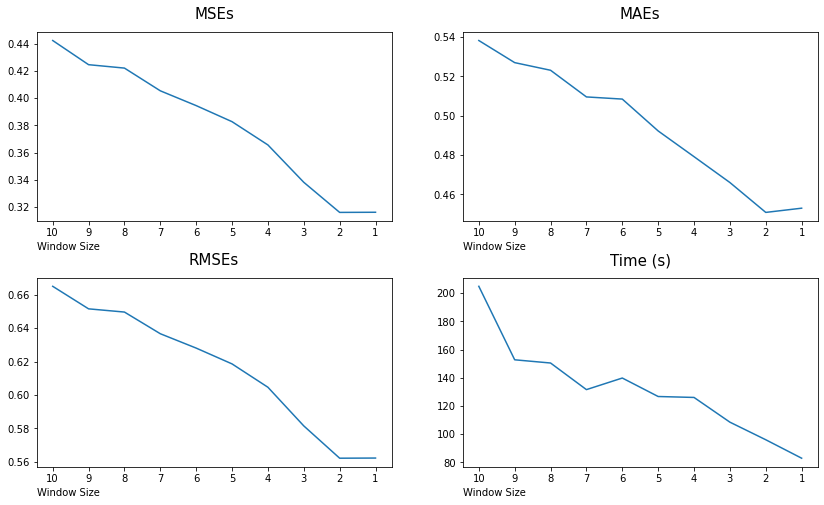

In [ ]:
win_sizes_str = [str(n) for n in win_sizes]

fig = plt.figure(figsize=(14,8))
gs = GridSpec(2,2) 

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])


ax0.plot(df_err_ws.to_numpy()[0,1:])
ax0.set_xticks(np.arange(10));ax0.set_xticklabels(win_sizes_str)
ax0.set_title("MSEs", {'fontsize': 15}, pad = 13)
ax0.set_xlabel("Window Size", loc="left")
ax1.plot(df_err_ws.to_numpy()[1,1:])
ax1.set_xticks(np.arange(10));ax1.set_xticklabels(win_sizes_str)
ax1.set_title("RMSEs", {'fontsize': 15}, pad = 13)
ax1.set_xlabel("Window Size", loc="left")
ax2.plot(df_err_ws.to_numpy()[2,1:])
ax2.set_xticks(np.arange(10));ax2.set_xticklabels(win_sizes_str)
ax2.set_title("MAEs", {'fontsize': 15}, pad = 13)
ax2.set_xlabel("Window Size", loc="left")
ax3.plot(df_err_ws.to_numpy()[4,1:])
ax3.set_xticks(np.arange(10));ax3.set_xticklabels(win_sizes_str)
ax3.set_title("Time (s)", {'fontsize': 15}, pad = 13)
ax3.set_xlabel("Window Size", loc="left")

gs.update(wspace=0.2, hspace=0.3)

plt.show()

Re-Extract X and y with Window Size = 2

In [19]:
# Extract X and y
window_size = 2

def df_to_X_y(df, window_size=window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X1, y1 = df_to_X_y(df)
print('X shape = ' + str(X1.shape) + ' and y shape = ' + str(y1.shape))

X shape = (363, 2, 937) and y shape = (363, 187)


In [20]:
# Divide into train, validate and test
days = np.shape(X1)[0]
lfw = days-28 # days before the last two weeks
lew = days-56 # days before the last six

X1_train, y1_train = X1[:lew], y1[:lew]
X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
X1_test, y1_test = X1[lfw:], y1[lfw:]

print('X_train shape = ' + str(X1_train.shape))
print('y_train shape = ' + str(y1_train.shape))
print('X_val shape = ' + str(X1_val.shape))
print('y_val shape = ' + str(y1_val.shape))
print('X_test shape = ' + str(X1_test.shape))
print('y_test shape = ' + str(y1_test.shape))

X_train shape = (307, 2, 937)
y_train shape = (307, 187)
X_val shape = (28, 2, 937)
y_val shape = (28, 187)
X_test shape = (28, 2, 937)
y_test shape = (28, 187)


In [21]:
# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
    east_training_std[i] = np.std(X1_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X1_train[:, :, i+187])
    north_training_std[i] = np.std(X1_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X1_train[:, :, i])
    temp_training_std[i] = np.std(X1_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X1_train, y1_train)
preprocess(X1_val, y1_val)
preprocess(X1_test, y1_test)

##### **Vanilla LSTM**

In [ ]:
vlstm_model = Sequential()
vlstm_model.add(InputLayer((window_size, 937)))
vlstm_model.add(LSTM(640))
vlstm_model.add(Dense(320, 'relu'))
vlstm_model.add(Dense(187, 'linear'))

vlstm_model.summary()

Model: "sequential_190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 640)               4039680   
                                                                 
 dense_756 (Dense)           (None, 320)               205120    
                                                                 
 dense_757 (Dense)           (None, 187)               60027     
                                                                 
Total params: 4,304,827
Trainable params: 4,304,827
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('vlstm_model/', save_best_only=True)
lh1 = LossHistory()
vlstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
vlstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp1, lh1])
vlstm_model = load_model('vlstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8538 - root_mean_squared_error: 0.9240

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 19s 2s/step - loss: 0.8538 - root_mean_squared_error: 0.9240 - val_loss: 0.3857 - val_root_mean_squared_error: 0.6210
Epoch 2/25
10/10 [==============================] - 4s 438ms/step - loss: 0.5925 - root_mean_squared_error: 0.7697 - val_loss: 0.4626 - val_root_mean_squared_error: 0.6801
Epoch 3/25
10/10 [==============================] - 4s 441ms/step - loss: 0.4302 - root_mean_squared_error: 0.6559 - val_loss: 0.4997 - val_root_mean_squared_error: 0.7069
Epoch 4/25
10/10 [==============================] - 4s 442ms/step - loss: 0.3186 - root_mean_squared_error: 0.5644 - val_loss: 0.4960 - val_root_mean_squared_error: 0.7043
Epoch 5/25
10/10 [==============================] - 5s 521ms/step - loss: 0.2396 - root_mean_squared_error: 0.4895 - val_loss: 0.4726 - val_root_mean_squared_error: 0.6875
Epoch 6/25
10/10 [==============================] - 5s 529ms/step - loss: 0.1892 - root_mean_squared_error: 0.4350 - val_loss: 0.4271 - val_root_mean_squ

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 17s 2s/step - loss: 0.1367 - root_mean_squared_error: 0.3698 - val_loss: 0.3603 - val_root_mean_squared_error: 0.6002
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1210 - root_mean_squared_error: 0.3478

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 15s 2s/step - loss: 0.1210 - root_mean_squared_error: 0.3478 - val_loss: 0.3370 - val_root_mean_squared_error: 0.5805
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1083 - root_mean_squared_error: 0.3290

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 19s 2s/step - loss: 0.1083 - root_mean_squared_error: 0.3290 - val_loss: 0.3221 - val_root_mean_squared_error: 0.5675
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0972 - root_mean_squared_error: 0.3117

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.0972 - root_mean_squared_error: 0.3117 - val_loss: 0.3101 - val_root_mean_squared_error: 0.5569
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0878 - root_mean_squared_error: 0.2962

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 19s 2s/step - loss: 0.0878 - root_mean_squared_error: 0.2962 - val_loss: 0.3002 - val_root_mean_squared_error: 0.5479
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0797 - root_mean_squared_error: 0.2823

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 19s 2s/step - loss: 0.0797 - root_mean_squared_error: 0.2823 - val_loss: 0.2952 - val_root_mean_squared_error: 0.5433
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0728 - root_mean_squared_error: 0.2698

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 14s 1s/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.2894 - val_root_mean_squared_error: 0.5380
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0670 - root_mean_squared_error: 0.2588

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0670 - root_mean_squared_error: 0.2588 - val_loss: 0.2816 - val_root_mean_squared_error: 0.5306
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0620 - root_mean_squared_error: 0.2490

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.2753 - val_root_mean_squared_error: 0.5247
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0573 - root_mean_squared_error: 0.2393

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 15s 2s/step - loss: 0.0573 - root_mean_squared_error: 0.2393 - val_loss: 0.2719 - val_root_mean_squared_error: 0.5215
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0532 - root_mean_squared_error: 0.2307

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0532 - root_mean_squared_error: 0.2307 - val_loss: 0.2669 - val_root_mean_squared_error: 0.5166
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0498 - root_mean_squared_error: 0.2232

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.2610 - val_root_mean_squared_error: 0.5109
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.2160

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0467 - root_mean_squared_error: 0.2160 - val_loss: 0.2557 - val_root_mean_squared_error: 0.5056
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.2099

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0441 - root_mean_squared_error: 0.2099 - val_loss: 0.2532 - val_root_mean_squared_error: 0.5032
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0414 - root_mean_squared_error: 0.2035

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0414 - root_mean_squared_error: 0.2035 - val_loss: 0.2501 - val_root_mean_squared_error: 0.5001
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0391 - root_mean_squared_error: 0.1978

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 15s 2s/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.2454 - val_root_mean_squared_error: 0.4954
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0371 - root_mean_squared_error: 0.1926

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.2415 - val_root_mean_squared_error: 0.4915
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0351 - root_mean_squared_error: 0.1873

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 15s 2s/step - loss: 0.0351 - root_mean_squared_error: 0.1873 - val_loss: 0.2378 - val_root_mean_squared_error: 0.4876


##### **Bidirectional LSTM**

In [ ]:
bilstm_model = Sequential()
bilstm_model.add(InputLayer((window_size, 937)))
bilstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bilstm_model.add(Bidirectional(LSTM(640)))
bilstm_model.add(Dense(640, 'relu'))
bilstm_model.add(Dense(320, 'relu'))
bilstm_model.add(Dense(187, 'linear'))

bilstm_model.summary()

Model: "sequential_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 2, 1280)          8079360   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 1280)             9835520   
 nal)                                                            
                                                                 
 dense_758 (Dense)           (None, 640)               819840    
                                                                 
 dense_759 (Dense)           (None, 320)               205120    
                                                                 
 dense_760 (Dense)           (None, 187)               60027     
                                                                 
Total params: 18,999,867
Trainable params: 18,999,86

In [ ]:
cp2 = ModelCheckpoint('bilstm_model/', save_best_only=True)
lh2 = LossHistory()
bilstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bilstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp2, lh2])
bilstm_model = load_model('bilstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8893 - root_mean_squared_error: 0.9430

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 100s 9s/step - loss: 0.8893 - root_mean_squared_error: 0.9430 - val_loss: 0.3547 - val_root_mean_squared_error: 0.5956
Epoch 2/25
10/10 [==============================] - 14s 1s/step - loss: 0.6356 - root_mean_squared_error: 0.7972 - val_loss: 0.5005 - val_root_mean_squared_error: 0.7074
Epoch 3/25
10/10 [==============================] - 14s 1s/step - loss: 0.4457 - root_mean_squared_error: 0.6676 - val_loss: 0.4882 - val_root_mean_squared_error: 0.6987
Epoch 4/25
10/10 [==============================] - 14s 1s/step - loss: 0.3211 - root_mean_squared_error: 0.5667 - val_loss: 0.4211 - val_root_mean_squared_error: 0.6489
Epoch 5/25
10/10 [==============================] - 14s 1s/step - loss: 0.2376 - root_mean_squared_error: 0.4875 - val_loss: 0.3715 - val_root_mean_squared_error: 0.6095
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1859 - root_mean_squared_error: 0.4312

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 65s 7s/step - loss: 0.1859 - root_mean_squared_error: 0.4312 - val_loss: 0.3092 - val_root_mean_squared_error: 0.5560
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1481 - root_mean_squared_error: 0.3849

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 64s 7s/step - loss: 0.1481 - root_mean_squared_error: 0.3849 - val_loss: 0.2848 - val_root_mean_squared_error: 0.5336
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1262 - root_mean_squared_error: 0.3552

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 73s 8s/step - loss: 0.1262 - root_mean_squared_error: 0.3552 - val_loss: 0.2804 - val_root_mean_squared_error: 0.5295
Epoch 9/25
10/10 [==============================] - 17s 2s/step - loss: 0.1083 - root_mean_squared_error: 0.3291 - val_loss: 0.2824 - val_root_mean_squared_error: 0.5314
Epoch 10/25
10/10 [==============================] - 17s 2s/step - loss: 0.0938 - root_mean_squared_error: 0.3062 - val_loss: 0.2841 - val_root_mean_squared_error: 0.5330
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0821 - root_mean_squared_error: 0.2866

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 75s 8s/step - loss: 0.0821 - root_mean_squared_error: 0.2866 - val_loss: 0.2790 - val_root_mean_squared_error: 0.5282
Epoch 12/25
10/10 [==============================] - 15s 2s/step - loss: 0.0729 - root_mean_squared_error: 0.2699 - val_loss: 0.2801 - val_root_mean_squared_error: 0.5292
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0649 - root_mean_squared_error: 0.2547

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 63s 7s/step - loss: 0.0649 - root_mean_squared_error: 0.2547 - val_loss: 0.2784 - val_root_mean_squared_error: 0.5276
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0586 - root_mean_squared_error: 0.2420

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 63s 7s/step - loss: 0.0586 - root_mean_squared_error: 0.2420 - val_loss: 0.2748 - val_root_mean_squared_error: 0.5242
Epoch 15/25
10/10 [==============================] - 14s 1s/step - loss: 0.0528 - root_mean_squared_error: 0.2298 - val_loss: 0.2749 - val_root_mean_squared_error: 0.5243
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.2196

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 64s 7s/step - loss: 0.0482 - root_mean_squared_error: 0.2196 - val_loss: 0.2713 - val_root_mean_squared_error: 0.5209
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.2107

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 64s 7s/step - loss: 0.0444 - root_mean_squared_error: 0.2107 - val_loss: 0.2695 - val_root_mean_squared_error: 0.5191
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0409 - root_mean_squared_error: 0.2022

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 62s 7s/step - loss: 0.0409 - root_mean_squared_error: 0.2022 - val_loss: 0.2671 - val_root_mean_squared_error: 0.5168
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0383 - root_mean_squared_error: 0.1957

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 63s 7s/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.2625 - val_root_mean_squared_error: 0.5124
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0358 - root_mean_squared_error: 0.1891

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 68s 7s/step - loss: 0.0358 - root_mean_squared_error: 0.1891 - val_loss: 0.2573 - val_root_mean_squared_error: 0.5073
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0332 - root_mean_squared_error: 0.1823

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 68s 7s/step - loss: 0.0332 - root_mean_squared_error: 0.1823 - val_loss: 0.2553 - val_root_mean_squared_error: 0.5053
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.1758

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 87s 9s/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.2518 - val_root_mean_squared_error: 0.5018
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0289 - root_mean_squared_error: 0.1699

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 79s 9s/step - loss: 0.0289 - root_mean_squared_error: 0.1699 - val_loss: 0.2479 - val_root_mean_squared_error: 0.4979
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0272 - root_mean_squared_error: 0.1648

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 87s 9s/step - loss: 0.0272 - root_mean_squared_error: 0.1648 - val_loss: 0.2439 - val_root_mean_squared_error: 0.4939
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1593

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 111s 12s/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.2411 - val_root_mean_squared_error: 0.4910


##### **Stacked LSTM**

In [ ]:
slstm_model = Sequential()
slstm_model.add(InputLayer((window_size, 937)))
slstm_model.add(LSTM(640, return_sequences=True))
slstm_model.add(LSTM(640))
slstm_model.add(Dense(320, 'relu'))
slstm_model.add(Dense(187, 'linear'))

slstm_model.summary()

Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_131 (LSTM)             (None, 2, 640)            4039680   
                                                                 
 lstm_132 (LSTM)             (None, 640)               3279360   
                                                                 
 dense_761 (Dense)           (None, 320)               205120    
                                                                 
 dense_762 (Dense)           (None, 187)               60027     
                                                                 
Total params: 7,584,187
Trainable params: 7,584,187
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp3 = ModelCheckpoint('slstm_model/', save_best_only=True)
lh3 = LossHistory()
slstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
slstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp3, lh3])
slstm_model = load_model('slstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9202 - root_mean_squared_error: 0.9593

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 52s 4s/step - loss: 0.9202 - root_mean_squared_error: 0.9593 - val_loss: 0.3447 - val_root_mean_squared_error: 0.5871
Epoch 2/25
10/10 [==============================] - 17s 2s/step - loss: 0.7235 - root_mean_squared_error: 0.8506 - val_loss: 0.4409 - val_root_mean_squared_error: 0.6640
Epoch 3/25
10/10 [==============================] - 17s 2s/step - loss: 0.5153 - root_mean_squared_error: 0.7179 - val_loss: 0.6132 - val_root_mean_squared_error: 0.7831
Epoch 4/25
10/10 [==============================] - 17s 2s/step - loss: 0.3739 - root_mean_squared_error: 0.6115 - val_loss: 0.5923 - val_root_mean_squared_error: 0.7696
Epoch 5/25
10/10 [==============================] - 17s 2s/step - loss: 0.2795 - root_mean_squared_error: 0.5287 - val_loss: 0.5150 - val_root_mean_squared_error: 0.7177
Epoch 6/25
10/10 [==============================] - 16s 2s/step - loss: 0.2242 - root_mean_squared_error: 0.4735 - val_loss: 0.4379 - val_root_mean_squared_error

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 42s 4s/step - loss: 0.1631 - root_mean_squared_error: 0.4038 - val_loss: 0.3080 - val_root_mean_squared_error: 0.5550
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1435 - root_mean_squared_error: 0.3788

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.1435 - root_mean_squared_error: 0.3788 - val_loss: 0.2905 - val_root_mean_squared_error: 0.5389
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1276 - root_mean_squared_error: 0.3571

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 41s 4s/step - loss: 0.1276 - root_mean_squared_error: 0.3571 - val_loss: 0.2863 - val_root_mean_squared_error: 0.5350
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.1158 - root_mean_squared_error: 0.3403

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 43s 5s/step - loss: 0.1158 - root_mean_squared_error: 0.3403 - val_loss: 0.2848 - val_root_mean_squared_error: 0.5336
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.1041 - root_mean_squared_error: 0.3227

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.1041 - root_mean_squared_error: 0.3227 - val_loss: 0.2842 - val_root_mean_squared_error: 0.5331
Epoch 13/25
10/10 [==============================] - 16s 2s/step - loss: 0.0945 - root_mean_squared_error: 0.3075 - val_loss: 0.2864 - val_root_mean_squared_error: 0.5352
Epoch 14/25
10/10 [==============================] - 16s 2s/step - loss: 0.0857 - root_mean_squared_error: 0.2928 - val_loss: 0.2844 - val_root_mean_squared_error: 0.5333
Epoch 15/25
10/10 [==============================] - 15s 2s/step - loss: 0.0783 - root_mean_squared_error: 0.2799 - val_loss: 0.2850 - val_root_mean_squared_error: 0.5339
Epoch 16/25
10/10 [==============================] - 16s 2s/step - loss: 0.0716 - root_mean_squared_error: 0.2677 - val_loss: 0.2858 - val_root_mean_squared_error: 0.5346
Epoch 17/25
10/10 [==============================] - 19s 2s/step - loss: 0.0660 - root_mean_squared_error: 0.2570 - val_loss: 0.2867 - val_root_mean_squared_

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0535 - root_mean_squared_error: 0.2313 - val_loss: 0.2825 - val_root_mean_squared_error: 0.5315
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0506 - root_mean_squared_error: 0.2249

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0506 - root_mean_squared_error: 0.2249 - val_loss: 0.2819 - val_root_mean_squared_error: 0.5309
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.2187

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0478 - root_mean_squared_error: 0.2187 - val_loss: 0.2803 - val_root_mean_squared_error: 0.5294
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.2125

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 33s 3s/step - loss: 0.0452 - root_mean_squared_error: 0.2125 - val_loss: 0.2779 - val_root_mean_squared_error: 0.5272
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0428 - root_mean_squared_error: 0.2068

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0428 - root_mean_squared_error: 0.2068 - val_loss: 0.2743 - val_root_mean_squared_error: 0.5237
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0405 - root_mean_squared_error: 0.2013

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 42s 4s/step - loss: 0.0405 - root_mean_squared_error: 0.2013 - val_loss: 0.2712 - val_root_mean_squared_error: 0.5208


Bi + Stacked

In [ ]:
bislstm_model = Sequential()
bislstm_model.add(InputLayer((window_size, 937)))
bislstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_model.add(LSTM(640, return_sequences=True))
bislstm_model.add(LSTM(640))
bislstm_model.add(Dense(320, 'relu'))
bislstm_model.add(Dense(187, 'linear'))

bislstm_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 2, 1280)          8079360   
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 2, 1280)          9835520   
 onal)                                                           
                                                                 
 lstm_4 (LSTM)               (None, 2, 640)            4917760   
                                                                 
 lstm_5 (LSTM)               (None, 640)               3279360   
                                                                 
 dense_44 (Dense)            (None, 320)               205120    
                                                                 
 dense_45 (Dense)            (None, 187)             

In [ ]:
cp31 = ModelCheckpoint('bislstm_model/', save_best_only=True)
lh31 = LossHistory()
bislstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bislstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp31, lh31])
bislstm_model = load_model('bislstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9687 - root_mean_squared_error: 0.9842

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 93s 9s/step - loss: 0.9687 - root_mean_squared_error: 0.9842 - val_loss: 0.3224 - val_root_mean_squared_error: 0.5678
Epoch 2/25
10/10 [==============================] - 56s 6s/step - loss: 0.8549 - root_mean_squared_error: 0.9246 - val_loss: 0.3789 - val_root_mean_squared_error: 0.6155
Epoch 3/25
10/10 [==============================] - 43s 4s/step - loss: 0.6021 - root_mean_squared_error: 0.7759 - val_loss: 0.7756 - val_root_mean_squared_error: 0.8807
Epoch 4/25
10/10 [==============================] - 51s 5s/step - loss: 0.4210 - root_mean_squared_error: 0.6489 - val_loss: 0.6586 - val_root_mean_squared_error: 0.8116
Epoch 5/25
10/10 [==============================] - 56s 5s/step - loss: 0.3108 - root_mean_squared_error: 0.5575 - val_loss: 0.4339 - val_root_mean_squared_error: 0.6587
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.2547 - root_mean_squared_error: 0.5047

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 114s 12s/step - loss: 0.2547 - root_mean_squared_error: 0.5047 - val_loss: 0.3046 - val_root_mean_squared_error: 0.5519
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.2243 - root_mean_squared_error: 0.4736

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 90s 9s/step - loss: 0.2243 - root_mean_squared_error: 0.4736 - val_loss: 0.2795 - val_root_mean_squared_error: 0.5287
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.2044 - root_mean_squared_error: 0.4521

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 79s 8s/step - loss: 0.2044 - root_mean_squared_error: 0.4521 - val_loss: 0.2681 - val_root_mean_squared_error: 0.5178
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1907 - root_mean_squared_error: 0.4367

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 76s 8s/step - loss: 0.1907 - root_mean_squared_error: 0.4367 - val_loss: 0.2675 - val_root_mean_squared_error: 0.5172
Epoch 10/25
10/10 [==============================] - 48s 5s/step - loss: 0.1825 - root_mean_squared_error: 0.4273 - val_loss: 0.2737 - val_root_mean_squared_error: 0.5231
Epoch 11/25
10/10 [==============================] - 55s 5s/step - loss: 0.1767 - root_mean_squared_error: 0.4204 - val_loss: 0.2769 - val_root_mean_squared_error: 0.5262
Epoch 12/25
10/10 [==============================] - 59s 6s/step - loss: 0.1713 - root_mean_squared_error: 0.4139 - val_loss: 0.2779 - val_root_mean_squared_error: 0.5272
Epoch 13/25
10/10 [==============================] - 75s 8s/step - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 0.2816 - val_root_mean_squared_error: 0.5306
Epoch 14/25
10/10 [==============================] - 68s 7s/step - loss: 0.1539 - root_mean_squared_error: 0.3923 - val_loss: 0.2848 - val_root_mean_squared_

##### **GRU**

In [22]:
gru_model = Sequential()
gru_model.add(InputLayer((window_size, 937)))
gru_model.add(GRU(640))
gru_model.add(Dense(320, 'relu'))
gru_model.add(Dense(187, 'linear'))

gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 640)               3031680   
                                                                 
 dense (Dense)               (None, 320)               205120    
                                                                 
 dense_1 (Dense)             (None, 187)               60027     
                                                                 
Total params: 3,296,827
Trainable params: 3,296,827
Non-trainable params: 0
_________________________________________________________________


In [23]:
cp4 = ModelCheckpoint('gru_model/', save_best_only=True)
lh4 = LossHistory()
gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
gru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp4, lh4])
gru_model = load_model('gru_model/')

Epoch 1/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.8624 - root_mean_squared_error: 0.9287

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 8s 635ms/step - loss: 0.8488 - root_mean_squared_error: 0.9213 - val_loss: 0.4268 - val_root_mean_squared_error: 0.6533
Epoch 2/25
10/10 [==============================] - 0s 31ms/step - loss: 0.5507 - root_mean_squared_error: 0.7421 - val_loss: 0.4935 - val_root_mean_squared_error: 0.7025
Epoch 3/25
10/10 [==============================] - 0s 33ms/step - loss: 0.3985 - root_mean_squared_error: 0.6313 - val_loss: 0.5221 - val_root_mean_squared_error: 0.7226
Epoch 4/25
10/10 [==============================] - 0s 36ms/step - loss: 0.2924 - root_mean_squared_error: 0.5407 - val_loss: 0.5038 - val_root_mean_squared_error: 0.7098
Epoch 5/25
10/10 [==============================] - 0s 42ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711 - val_loss: 0.4543 - val_root_mean_squared_error: 0.6740
Epoch 6/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1776 - root_mean_squared_error: 0.4214

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 5s 568ms/step - loss: 0.1750 - root_mean_squared_error: 0.4183 - val_loss: 0.4038 - val_root_mean_squared_error: 0.6354
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1462 - root_mean_squared_error: 0.3823

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 5s 503ms/step - loss: 0.1462 - root_mean_squared_error: 0.3823 - val_loss: 0.3620 - val_root_mean_squared_error: 0.6017
Epoch 8/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1259 - root_mean_squared_error: 0.3549

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 375ms/step - loss: 0.1272 - root_mean_squared_error: 0.3567 - val_loss: 0.3262 - val_root_mean_squared_error: 0.5711
Epoch 9/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1128 - root_mean_squared_error: 0.3359

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 486ms/step - loss: 0.1126 - root_mean_squared_error: 0.3356 - val_loss: 0.3055 - val_root_mean_squared_error: 0.5527
Epoch 10/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1015 - root_mean_squared_error: 0.3187

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 363ms/step - loss: 0.1008 - root_mean_squared_error: 0.3175 - val_loss: 0.2867 - val_root_mean_squared_error: 0.5355
Epoch 11/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0918 - root_mean_squared_error: 0.3030

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 465ms/step - loss: 0.0908 - root_mean_squared_error: 0.3014 - val_loss: 0.2734 - val_root_mean_squared_error: 0.5228
Epoch 12/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0818 - root_mean_squared_error: 0.2860

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 424ms/step - loss: 0.0822 - root_mean_squared_error: 0.2867 - val_loss: 0.2631 - val_root_mean_squared_error: 0.5130
Epoch 13/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0751 - root_mean_squared_error: 0.2740

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 344ms/step - loss: 0.0750 - root_mean_squared_error: 0.2738 - val_loss: 0.2551 - val_root_mean_squared_error: 0.5051
Epoch 14/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0691 - root_mean_squared_error: 0.2629

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 400ms/step - loss: 0.0688 - root_mean_squared_error: 0.2623 - val_loss: 0.2503 - val_root_mean_squared_error: 0.5003
Epoch 15/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0639 - root_mean_squared_error: 0.2529

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 434ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_loss: 0.2445 - val_root_mean_squared_error: 0.4945
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0591 - root_mean_squared_error: 0.2431

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 452ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.2397 - val_root_mean_squared_error: 0.4895
Epoch 17/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0553 - root_mean_squared_error: 0.2352

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 406ms/step - loss: 0.0551 - root_mean_squared_error: 0.2348 - val_loss: 0.2355 - val_root_mean_squared_error: 0.4852
Epoch 18/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0518 - root_mean_squared_error: 0.2276

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 424ms/step - loss: 0.0516 - root_mean_squared_error: 0.2272 - val_loss: 0.2326 - val_root_mean_squared_error: 0.4823
Epoch 19/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.2207

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 5s 505ms/step - loss: 0.0486 - root_mean_squared_error: 0.2205 - val_loss: 0.2281 - val_root_mean_squared_error: 0.4776
Epoch 20/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0458 - root_mean_squared_error: 0.2139

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 376ms/step - loss: 0.0459 - root_mean_squared_error: 0.2142 - val_loss: 0.2265 - val_root_mean_squared_error: 0.4759
Epoch 21/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.2083

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 356ms/step - loss: 0.0433 - root_mean_squared_error: 0.2081 - val_loss: 0.2232 - val_root_mean_squared_error: 0.4724
Epoch 22/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0410 - root_mean_squared_error: 0.2025

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 364ms/step - loss: 0.0410 - root_mean_squared_error: 0.2026 - val_loss: 0.2214 - val_root_mean_squared_error: 0.4705
Epoch 23/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.1967

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 370ms/step - loss: 0.0388 - root_mean_squared_error: 0.1971 - val_loss: 0.2182 - val_root_mean_squared_error: 0.4671
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0371 - root_mean_squared_error: 0.1926

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 363ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.2138 - val_root_mean_squared_error: 0.4624
Epoch 25/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0355 - root_mean_squared_error: 0.1884

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 3s 366ms/step - loss: 0.0353 - root_mean_squared_error: 0.1878 - val_loss: 0.2110 - val_root_mean_squared_error: 0.4594


##### **Bidirectional GRU**

In [ ]:
bigru_model = Sequential()
bigru_model.add(InputLayer((window_size, 937)))
bigru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bigru_model.add(Bidirectional(GRU(640)))
bigru_model.add(Dense(640, 'relu'))
bigru_model.add(Dense(320, 'relu'))
bigru_model.add(Dense(187, 'linear'))

bigru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 2, 1280)          6063360   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1280)             7380480   
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 640)               819840    
                                                                 
 dense_7 (Dense)             (None, 320)               205120    
                                                                 
 dense_8 (Dense)             (None, 187)               60027     
                                                                 
Total params: 14,528,827
Trainable params: 14,528,827


In [ ]:
cp41 = ModelCheckpoint('bigru_model/', save_best_only=True)
lh41 = LossHistory()
bigru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bigru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp41, lh41])
bigru_model = load_model('bigru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7799 - root_mean_squared_error: 0.8831

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.7799 - root_mean_squared_error: 0.8831 - val_loss: 0.4392 - val_root_mean_squared_error: 0.6627
Epoch 2/25
10/10 [==============================] - 1s 147ms/step - loss: 0.5139 - root_mean_squared_error: 0.7168 - val_loss: 0.4795 - val_root_mean_squared_error: 0.6925
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.3497 - root_mean_squared_error: 0.5914

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 17s 2s/step - loss: 0.3497 - root_mean_squared_error: 0.5914 - val_loss: 0.4219 - val_root_mean_squared_error: 0.6495
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2363 - root_mean_squared_error: 0.4862

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 17s 2s/step - loss: 0.2363 - root_mean_squared_error: 0.4862 - val_loss: 0.3318 - val_root_mean_squared_error: 0.5760
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1635 - root_mean_squared_error: 0.4043

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 17s 2s/step - loss: 0.1635 - root_mean_squared_error: 0.4043 - val_loss: 0.2799 - val_root_mean_squared_error: 0.5291
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1252 - root_mean_squared_error: 0.3539

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 17s 2s/step - loss: 0.1252 - root_mean_squared_error: 0.3539 - val_loss: 0.2589 - val_root_mean_squared_error: 0.5088
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1045 - root_mean_squared_error: 0.3232

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 18s 2s/step - loss: 0.1045 - root_mean_squared_error: 0.3232 - val_loss: 0.2516 - val_root_mean_squared_error: 0.5016
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.0897 - root_mean_squared_error: 0.2996

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 19s 2s/step - loss: 0.0897 - root_mean_squared_error: 0.2996 - val_loss: 0.2461 - val_root_mean_squared_error: 0.4960
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0783 - root_mean_squared_error: 0.2799

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 18s 2s/step - loss: 0.0783 - root_mean_squared_error: 0.2799 - val_loss: 0.2433 - val_root_mean_squared_error: 0.4933
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0683 - root_mean_squared_error: 0.2614

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 19s 2s/step - loss: 0.0683 - root_mean_squared_error: 0.2614 - val_loss: 0.2394 - val_root_mean_squared_error: 0.4893
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0609 - root_mean_squared_error: 0.2468

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 27s 3s/step - loss: 0.0609 - root_mean_squared_error: 0.2468 - val_loss: 0.2337 - val_root_mean_squared_error: 0.4834
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0552 - root_mean_squared_error: 0.2350

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 27s 3s/step - loss: 0.0552 - root_mean_squared_error: 0.2350 - val_loss: 0.2292 - val_root_mean_squared_error: 0.4788
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2244

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 26s 3s/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.2241 - val_root_mean_squared_error: 0.4734
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.2150

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 26s 3s/step - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.2210 - val_root_mean_squared_error: 0.4701
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.2059

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0424 - root_mean_squared_error: 0.2059 - val_loss: 0.2158 - val_root_mean_squared_error: 0.4645
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.1979

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0392 - root_mean_squared_error: 0.1979 - val_loss: 0.2110 - val_root_mean_squared_error: 0.4594
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0362 - root_mean_squared_error: 0.1903

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0362 - root_mean_squared_error: 0.1903 - val_loss: 0.2063 - val_root_mean_squared_error: 0.4542
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0338 - root_mean_squared_error: 0.1838

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.2031 - val_root_mean_squared_error: 0.4507
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0314 - root_mean_squared_error: 0.1773

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0314 - root_mean_squared_error: 0.1773 - val_loss: 0.1987 - val_root_mean_squared_error: 0.4458
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0296 - root_mean_squared_error: 0.1721

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0296 - root_mean_squared_error: 0.1721 - val_loss: 0.1945 - val_root_mean_squared_error: 0.4411
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0279 - root_mean_squared_error: 0.1670

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.0279 - root_mean_squared_error: 0.1670 - val_loss: 0.1913 - val_root_mean_squared_error: 0.4374
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0262 - root_mean_squared_error: 0.1618

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.1867 - val_root_mean_squared_error: 0.4320
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0246 - root_mean_squared_error: 0.1569

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.1835 - val_root_mean_squared_error: 0.4283
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.1522

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.1801 - val_root_mean_squared_error: 0.4244
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0218 - root_mean_squared_error: 0.1477

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0218 - root_mean_squared_error: 0.1477 - val_loss: 0.1761 - val_root_mean_squared_error: 0.4196


##### **Stacked GRU**

In [ ]:
sgru_model = Sequential()
sgru_model.add(InputLayer((window_size, 937)))
sgru_model.add(GRU(640, return_sequences=True))
sgru_model.add(GRU(640))
sgru_model.add(Dense(320, 'relu'))
sgru_model.add(Dense(187, 'linear'))

sgru_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 2, 640)            3031680   
                                                                 
 gru_9 (GRU)                 (None, 640)               2461440   
                                                                 
 dense_14 (Dense)            (None, 320)               205120    
                                                                 
 dense_15 (Dense)            (None, 187)               60027     
                                                                 
Total params: 5,758,267
Trainable params: 5,758,267
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp42 = ModelCheckpoint('sgru_model/', save_best_only=True)
lh42 = LossHistory()
sgru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
sgru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp42, lh42])
sgru_model = load_model('sgru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8627 - root_mean_squared_error: 0.9288

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.8627 - root_mean_squared_error: 0.9288 - val_loss: 0.3960 - val_root_mean_squared_error: 0.6293
Epoch 2/25
10/10 [==============================] - 2s 193ms/step - loss: 0.6179 - root_mean_squared_error: 0.7861 - val_loss: 0.5033 - val_root_mean_squared_error: 0.7094
Epoch 3/25
10/10 [==============================] - 2s 167ms/step - loss: 0.4463 - root_mean_squared_error: 0.6680 - val_loss: 0.5457 - val_root_mean_squared_error: 0.7387
Epoch 4/25
10/10 [==============================] - 2s 175ms/step - loss: 0.3247 - root_mean_squared_error: 0.5698 - val_loss: 0.4876 - val_root_mean_squared_error: 0.6983
Epoch 5/25
10/10 [==============================] - 2s 163ms/step - loss: 0.2374 - root_mean_squared_error: 0.4872 - val_loss: 0.3971 - val_root_mean_squared_error: 0.6301
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1819 - root_mean_squared_error: 0.4265

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 912ms/step - loss: 0.1819 - root_mean_squared_error: 0.4265 - val_loss: 0.3059 - val_root_mean_squared_error: 0.5530
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1478 - root_mean_squared_error: 0.3845

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.1478 - root_mean_squared_error: 0.3845 - val_loss: 0.2668 - val_root_mean_squared_error: 0.5165
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1254 - root_mean_squared_error: 0.3541

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 9s 956ms/step - loss: 0.1254 - root_mean_squared_error: 0.3541 - val_loss: 0.2558 - val_root_mean_squared_error: 0.5058
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1104 - root_mean_squared_error: 0.3322

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 9s 954ms/step - loss: 0.1104 - root_mean_squared_error: 0.3322 - val_loss: 0.2502 - val_root_mean_squared_error: 0.5002
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0983 - root_mean_squared_error: 0.3136

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 713ms/step - loss: 0.0983 - root_mean_squared_error: 0.3136 - val_loss: 0.2471 - val_root_mean_squared_error: 0.4970
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0881 - root_mean_squared_error: 0.2968

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 761ms/step - loss: 0.0881 - root_mean_squared_error: 0.2968 - val_loss: 0.2465 - val_root_mean_squared_error: 0.4965
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0799 - root_mean_squared_error: 0.2827

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 707ms/step - loss: 0.0799 - root_mean_squared_error: 0.2827 - val_loss: 0.2450 - val_root_mean_squared_error: 0.4949
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0728 - root_mean_squared_error: 0.2698

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 899ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.2420 - val_root_mean_squared_error: 0.4919
Epoch 14/25
10/10 [==============================] - 2s 182ms/step - loss: 0.0667 - root_mean_squared_error: 0.2582 - val_loss: 0.2421 - val_root_mean_squared_error: 0.4920
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0616 - root_mean_squared_error: 0.2482

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 9s 929ms/step - loss: 0.0616 - root_mean_squared_error: 0.2482 - val_loss: 0.2351 - val_root_mean_squared_error: 0.4848
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0571 - root_mean_squared_error: 0.2389

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 905ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.2342 - val_root_mean_squared_error: 0.4839
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0532 - root_mean_squared_error: 0.2306

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 801ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.2302 - val_root_mean_squared_error: 0.4798
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.2235

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 719ms/step - loss: 0.0500 - root_mean_squared_error: 0.2235 - val_loss: 0.2261 - val_root_mean_squared_error: 0.4755
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.2163

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 9s 948ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.2226 - val_root_mean_squared_error: 0.4718
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.2098

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 885ms/step - loss: 0.0440 - root_mean_squared_error: 0.2098 - val_loss: 0.2175 - val_root_mean_squared_error: 0.4664
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0415 - root_mean_squared_error: 0.2037

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 820ms/step - loss: 0.0415 - root_mean_squared_error: 0.2037 - val_loss: 0.2130 - val_root_mean_squared_error: 0.4615
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0393 - root_mean_squared_error: 0.1983

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 753ms/step - loss: 0.0393 - root_mean_squared_error: 0.1983 - val_loss: 0.2094 - val_root_mean_squared_error: 0.4576
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0373 - root_mean_squared_error: 0.1932

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 792ms/step - loss: 0.0373 - root_mean_squared_error: 0.1932 - val_loss: 0.2039 - val_root_mean_squared_error: 0.4515
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0354 - root_mean_squared_error: 0.1882

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 859ms/step - loss: 0.0354 - root_mean_squared_error: 0.1882 - val_loss: 0.1985 - val_root_mean_squared_error: 0.4455
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0336 - root_mean_squared_error: 0.1833

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 794ms/step - loss: 0.0336 - root_mean_squared_error: 0.1833 - val_loss: 0.1956 - val_root_mean_squared_error: 0.4423


Bi + Stacked

In [ ]:
bisgru_model = Sequential()
bisgru_model.add(InputLayer((window_size, 937)))
bisgru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bisgru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bisgru_model.add(GRU(640, return_sequences=True))
bisgru_model.add(GRU(640))
bisgru_model.add(Dense(320, 'relu'))
bisgru_model.add(Dense(187, 'linear'))

bisgru_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 2, 1280)          6063360   
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 2, 1280)          7380480   
 nal)                                                            
                                                                 
 gru_21 (GRU)                (None, 2, 640)            3690240   
                                                                 
 gru_22 (GRU)                (None, 640)               2461440   
                                                                 
 dense_34 (Dense)            (None, 320)               205120    
                                                                 
 dense_35 (Dense)            (None, 187)             

In [ ]:
cp43 = ModelCheckpoint('bisgru_model/', save_best_only=True)
lh43 = LossHistory()
bisgru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bisgru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp43, lh43])
bisgru_model = load_model('bisgru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.1767 - root_mean_squared_error: 0.4203

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 62s 5s/step - loss: 0.1767 - root_mean_squared_error: 0.4203 - val_loss: 0.2371 - val_root_mean_squared_error: 0.4869
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.1418 - root_mean_squared_error: 0.3765

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 47s 5s/step - loss: 0.1418 - root_mean_squared_error: 0.3765 - val_loss: 0.2291 - val_root_mean_squared_error: 0.4787
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3452

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 44s 5s/step - loss: 0.1192 - root_mean_squared_error: 0.3452 - val_loss: 0.2276 - val_root_mean_squared_error: 0.4770
Epoch 4/25
10/10 [==============================] - 22s 2s/step - loss: 0.1037 - root_mean_squared_error: 0.3220 - val_loss: 0.2374 - val_root_mean_squared_error: 0.4873
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.0890 - root_mean_squared_error: 0.2983

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.0890 - root_mean_squared_error: 0.2983 - val_loss: 0.2248 - val_root_mean_squared_error: 0.4741
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.0775 - root_mean_squared_error: 0.2783

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 48s 5s/step - loss: 0.0775 - root_mean_squared_error: 0.2783 - val_loss: 0.2237 - val_root_mean_squared_error: 0.4730
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.0682 - root_mean_squared_error: 0.2612

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.0682 - root_mean_squared_error: 0.2612 - val_loss: 0.2235 - val_root_mean_squared_error: 0.4727
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.0615 - root_mean_squared_error: 0.2480

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0615 - root_mean_squared_error: 0.2480 - val_loss: 0.2193 - val_root_mean_squared_error: 0.4683
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0560 - root_mean_squared_error: 0.2367

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 47s 5s/step - loss: 0.0560 - root_mean_squared_error: 0.2367 - val_loss: 0.2134 - val_root_mean_squared_error: 0.4620
Epoch 10/25
10/10 [==============================] - 22s 2s/step - loss: 0.0516 - root_mean_squared_error: 0.2270 - val_loss: 0.2138 - val_root_mean_squared_error: 0.4624
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.2179

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 47s 5s/step - loss: 0.0475 - root_mean_squared_error: 0.2179 - val_loss: 0.2085 - val_root_mean_squared_error: 0.4566
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0442 - root_mean_squared_error: 0.2102

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 51s 5s/step - loss: 0.0442 - root_mean_squared_error: 0.2102 - val_loss: 0.2040 - val_root_mean_squared_error: 0.4517
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.2049

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 53s 6s/step - loss: 0.0420 - root_mean_squared_error: 0.2049 - val_loss: 0.1978 - val_root_mean_squared_error: 0.4448
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0397 - root_mean_squared_error: 0.1993

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 49s 5s/step - loss: 0.0397 - root_mean_squared_error: 0.1993 - val_loss: 0.1932 - val_root_mean_squared_error: 0.4396
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0370 - root_mean_squared_error: 0.1925

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0370 - root_mean_squared_error: 0.1925 - val_loss: 0.1921 - val_root_mean_squared_error: 0.4383
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0342 - root_mean_squared_error: 0.1848

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0342 - root_mean_squared_error: 0.1848 - val_loss: 0.1900 - val_root_mean_squared_error: 0.4359
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1778

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4277
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0297 - root_mean_squared_error: 0.1725

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.0297 - root_mean_squared_error: 0.1725 - val_loss: 0.1779 - val_root_mean_squared_error: 0.4218
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0274 - root_mean_squared_error: 0.1655

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 50s 5s/step - loss: 0.0274 - root_mean_squared_error: 0.1655 - val_loss: 0.1729 - val_root_mean_squared_error: 0.4158
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.1596

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 65s 7s/step - loss: 0.0255 - root_mean_squared_error: 0.1596 - val_loss: 0.1707 - val_root_mean_squared_error: 0.4131
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0240 - root_mean_squared_error: 0.1550

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 78s 8s/step - loss: 0.0240 - root_mean_squared_error: 0.1550 - val_loss: 0.1618 - val_root_mean_squared_error: 0.4023
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0231 - root_mean_squared_error: 0.1518

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 89s 9s/step - loss: 0.0231 - root_mean_squared_error: 0.1518 - val_loss: 0.1613 - val_root_mean_squared_error: 0.4016
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0214 - root_mean_squared_error: 0.1463

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 94s 10s/step - loss: 0.0214 - root_mean_squared_error: 0.1463 - val_loss: 0.1612 - val_root_mean_squared_error: 0.4014
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.1437

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 105s 11s/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.1538 - val_root_mean_squared_error: 0.3922
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0191 - root_mean_squared_error: 0.1383

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 81s 8s/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.1531 - val_root_mean_squared_error: 0.3912


##### **1D CNN** *(kernel size = 4)*

In [ ]:
# Window Size = 6

window_size2 = 6

def df_to_X_y(df, window_size=window_size2):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X2, y2 = df_to_X_y(df)
print('X shape = ' + str(X2.shape) + ' and y shape = ' + str(y2.shape))

# Divide into train, validate and test
days = np.shape(X2)[0]
lfw = days-28 # days before the last two weeks
lew = days-56 # days before the last six

X2_train, y2_train = X2[:lew], y2[:lew]
X2_val, y2_val = X2[lew:lfw], y2[lew:lfw]
X2_test, y2_test = X2[lfw:], y2[lfw:]

print('X_train shape = ' + str(X2_train.shape))
print('y_train shape = ' + str(y2_train.shape))
print('X_val shape = ' + str(X2_val.shape))
print('y_val shape = ' + str(y2_val.shape))
print('X_test shape = ' + str(X2_test.shape))
print('y_test shape = ' + str(y2_test.shape))

# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X2_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X2_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X2_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X2_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X2_train[:, :, i+2*187])
    east_training_std[i] = np.std(X2_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X2_train[:, :, i+187])
    north_training_std[i] = np.std(X2_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X2_train[:, :, i])
    temp_training_std[i] = np.std(X2_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X2_train, y2_train)
preprocess(X2_val, y2_val)
preprocess(X2_test, y2_test)

X shape = (359, 6, 937) and y shape = (359, 187)
X_train shape = (303, 6, 937)
y_train shape = (303, 187)
X_val shape = (28, 6, 937)
y_val shape = (28, 187)
X_test shape = (28, 6, 937)
y_test shape = (28, 187)


In [ ]:
cnn_k4_model = Sequential()
cnn_k4_model.add(InputLayer((window_size2, 937)))
cnn_k4_model.add(Conv1D(640, kernel_size=4, activation='relu'))
cnn_k4_model.add(Flatten())
cnn_k4_model.add(Dense(640, 'relu'))
cnn_k4_model.add(Dense(320, 'relu'))
cnn_k4_model.add(Dense(187, 'linear'))

cnn_k4_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 3, 640)            2399360   
                                                                 
 flatten_4 (Flatten)         (None, 1920)              0         
                                                                 
 dense_41 (Dense)            (None, 640)               1229440   
                                                                 
 dense_42 (Dense)            (None, 320)               205120    
                                                                 
 dense_43 (Dense)            (None, 187)               60027     
                                                                 
Total params: 3,893,947
Trainable params: 3,893,947
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp5 = ModelCheckpoint('cnn_k4_model/', save_best_only=True)
lh5 = LossHistory()
cnn_k4_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
cnn_k4_model.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=25, callbacks=[cp5, lh5])
cnn_k4_model = load_model('cnn_k4_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8076 - root_mean_squared_error: 0.8987INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 181ms/step - loss: 0.8076 - root_mean_squared_error: 0.8987 - val_loss: 0.4687 - val_root_mean_squared_error: 0.6846
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.4542 - root_mean_squared_error: 0.6739INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 167ms/step - loss: 0.4542 - root_mean_squared_error: 0.6739 - val_loss: 0.4606 - val_root_mean_squared_error: 0.6787
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.3107 - root_mean_squared_error: 0.5574INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 162ms/step - loss: 0.3107 - root_mean_squared_error: 0.5574 - val_loss: 0.4525 - val_root_mean_squared_error: 0.6727
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2218 - root_mean_squared_error: 0.4710INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 165ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710 - val_loss: 0.4266 - val_root_mean_squared_error: 0.6532
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1671 - root_mean_squared_error: 0.4088INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 171ms/step - loss: 0.1671 - root_mean_squared_error: 0.4088 - val_loss: 0.4094 - val_root_mean_squared_error: 0.6398
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1366 - root_mean_squared_error: 0.3696INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 249ms/step - loss: 0.1366 - root_mean_squared_error: 0.3696 - val_loss: 0.3899 - val_root_mean_squared_error: 0.6245
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1167 - root_mean_squared_error: 0.3416INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 182ms/step - loss: 0.1167 - root_mean_squared_error: 0.3416 - val_loss: 0.3774 - val_root_mean_squared_error: 0.6143
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1027 - root_mean_squared_error: 0.3205INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 158ms/step - loss: 0.1027 - root_mean_squared_error: 0.3205 - val_loss: 0.3636 - val_root_mean_squared_error: 0.6030
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0920 - root_mean_squared_error: 0.3033INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 176ms/step - loss: 0.0920 - root_mean_squared_error: 0.3033 - val_loss: 0.3587 - val_root_mean_squared_error: 0.5989
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0830 - root_mean_squared_error: 0.2881INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 168ms/step - loss: 0.0830 - root_mean_squared_error: 0.2881 - val_loss: 0.3512 - val_root_mean_squared_error: 0.5926
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0753 - root_mean_squared_error: 0.2745INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 163ms/step - loss: 0.0753 - root_mean_squared_error: 0.2745 - val_loss: 0.3453 - val_root_mean_squared_error: 0.5876
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0685 - root_mean_squared_error: 0.2617INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 174ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617 - val_loss: 0.3406 - val_root_mean_squared_error: 0.5836
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0632 - root_mean_squared_error: 0.2514INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 187ms/step - loss: 0.0632 - root_mean_squared_error: 0.2514 - val_loss: 0.3372 - val_root_mean_squared_error: 0.5807
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0579 - root_mean_squared_error: 0.2406INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 207ms/step - loss: 0.0579 - root_mean_squared_error: 0.2406 - val_loss: 0.3347 - val_root_mean_squared_error: 0.5785
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.2319INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 164ms/step - loss: 0.0538 - root_mean_squared_error: 0.2319 - val_loss: 0.3303 - val_root_mean_squared_error: 0.5747
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0498 - root_mean_squared_error: 0.2231INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 230ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_loss: 0.3278 - val_root_mean_squared_error: 0.5725
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.2159INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 217ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.3252 - val_root_mean_squared_error: 0.5702
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.2088INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 213ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088 - val_loss: 0.3237 - val_root_mean_squared_error: 0.5690
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0409 - root_mean_squared_error: 0.2023INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 343ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.3194 - val_root_mean_squared_error: 0.5651
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.1968INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 207ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968 - val_loss: 0.3176 - val_root_mean_squared_error: 0.5635
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0370 - root_mean_squared_error: 0.1924INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 194ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924 - val_loss: 0.3154 - val_root_mean_squared_error: 0.5616
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0350 - root_mean_squared_error: 0.1872INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 280ms/step - loss: 0.0350 - root_mean_squared_error: 0.1872 - val_loss: 0.3103 - val_root_mean_squared_error: 0.5570
Epoch 23/25
10/10 [==============================] - 1s 151ms/step - loss: 0.0340 - root_mean_squared_error: 0.1843 - val_loss: 0.3115 - val_root_mean_squared_error: 0.5581
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0317 - root_mean_squared_error: 0.1780INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 231ms/step - loss: 0.0317 - root_mean_squared_error: 0.1780 - val_loss: 0.3087 - val_root_mean_squared_error: 0.5556
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0300 - root_mean_squared_error: 0.1733INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 309ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733 - val_loss: 0.3051 - val_root_mean_squared_error: 0.5524


##### **1D CNN** *(kernel size = 2)*

In [ ]:
# Window Size = 4

window_size3 = 4

def df_to_X_y(df, window_size=window_size3):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X3, y3 = df_to_X_y(df)
print('X shape = ' + str(X3.shape) + ' and y shape = ' + str(y3.shape))

# Divide into train, validate and test
days = np.shape(X3)[0]
lfw = days-28 # days before the last two weeks
lew = days-56 # days before the last six

X3_train, y3_train = X3[:lew], y3[:lew]
X3_val, y3_val = X3[lew:lfw], y3[lew:lfw]
X3_test, y3_test = X3[lfw:], y3[lfw:]

print('X_train shape = ' + str(X3_train.shape))
print('y_train shape = ' + str(y3_train.shape))
print('X_val shape = ' + str(X3_val.shape))
print('y_val shape = ' + str(y3_val.shape))
print('X_test shape = ' + str(X3_test.shape))
print('y_test shape = ' + str(y3_test.shape))

# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X3_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X3_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X3_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X3_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X3_train[:, :, i+2*187])
    east_training_std[i] = np.std(X3_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X3_train[:, :, i+187])
    north_training_std[i] = np.std(X3_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X3_train[:, :, i])
    temp_training_std[i] = np.std(X3_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X3_train, y3_train)
preprocess(X3_val, y3_val)
preprocess(X3_test, y3_test)

X shape = (361, 4, 937) and y shape = (361, 187)
X_train shape = (305, 4, 937)
y_train shape = (305, 187)
X_val shape = (28, 4, 937)
y_val shape = (28, 187)
X_test shape = (28, 4, 937)
y_test shape = (28, 187)


In [ ]:
cnn_k2_model = Sequential()
cnn_k2_model.add(InputLayer((window_size3, 937)))
cnn_k2_model.add(Conv1D(640, kernel_size=2, activation='relu'))
cnn_k2_model.add(Flatten())
cnn_k2_model.add(Dense(640, 'relu'))
cnn_k2_model.add(Dense(320, 'relu'))
cnn_k2_model.add(Dense(187, 'linear'))

cnn_k2_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 3, 640)            1200000   
                                                                 
 flatten_3 (Flatten)         (None, 1920)              0         
                                                                 
 dense_38 (Dense)            (None, 640)               1229440   
                                                                 
 dense_39 (Dense)            (None, 320)               205120    
                                                                 
 dense_40 (Dense)            (None, 187)               60027     
                                                                 
Total params: 2,694,587
Trainable params: 2,694,587
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp6 = ModelCheckpoint('cnn_k2_model/', save_best_only=True)
lh6 = LossHistory()
cnn_k2_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
cnn_k2_model.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=25, callbacks=[cp6, lh6])
cnn_k2_model = load_model('cnn_k2_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9000 - root_mean_squared_error: 0.9487INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 5s 416ms/step - loss: 0.9000 - root_mean_squared_error: 0.9487 - val_loss: 0.4143 - val_root_mean_squared_error: 0.6436
Epoch 2/25
10/10 [==============================] - 3s 305ms/step - loss: 0.5960 - root_mean_squared_error: 0.7720 - val_loss: 0.4306 - val_root_mean_squared_error: 0.6562
Epoch 3/25
10/10 [==============================] - 3s 251ms/step - loss: 0.4338 - root_mean_squared_error: 0.6587 - val_loss: 0.4276 - val_root_mean_squared_error: 0.6539
Epoch 4/25
10/10 [==============================] - 3s 301ms/step - loss: 0.3064 - root_mean_squared_error: 0.5536 - val_loss: 0.4185 - val_root_mean_squared_error: 0.6469
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2163 - root_mean_squared_error: 0.4651INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 5s 533ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651 - val_loss: 0.3999 - val_root_mean_squared_error: 0.6324
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1616 - root_mean_squared_error: 0.4020INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 437ms/step - loss: 0.1616 - root_mean_squared_error: 0.4020 - val_loss: 0.3774 - val_root_mean_squared_error: 0.6143
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1317 - root_mean_squared_error: 0.3629INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 427ms/step - loss: 0.1317 - root_mean_squared_error: 0.3629 - val_loss: 0.3612 - val_root_mean_squared_error: 0.6010
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1147 - root_mean_squared_error: 0.3387INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 385ms/step - loss: 0.1147 - root_mean_squared_error: 0.3387 - val_loss: 0.3507 - val_root_mean_squared_error: 0.5922
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1019 - root_mean_squared_error: 0.3192INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 364ms/step - loss: 0.1019 - root_mean_squared_error: 0.3192 - val_loss: 0.3381 - val_root_mean_squared_error: 0.5815
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0917 - root_mean_squared_error: 0.3028INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 418ms/step - loss: 0.0917 - root_mean_squared_error: 0.3028 - val_loss: 0.3317 - val_root_mean_squared_error: 0.5760
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0823 - root_mean_squared_error: 0.2869INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 380ms/step - loss: 0.0823 - root_mean_squared_error: 0.2869 - val_loss: 0.3243 - val_root_mean_squared_error: 0.5694
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0745 - root_mean_squared_error: 0.2730INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 350ms/step - loss: 0.0745 - root_mean_squared_error: 0.2730 - val_loss: 0.3211 - val_root_mean_squared_error: 0.5666
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0677 - root_mean_squared_error: 0.2601INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 3s 363ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601 - val_loss: 0.3163 - val_root_mean_squared_error: 0.5624
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0615 - root_mean_squared_error: 0.2480INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 397ms/step - loss: 0.0615 - root_mean_squared_error: 0.2480 - val_loss: 0.3095 - val_root_mean_squared_error: 0.5563
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0567 - root_mean_squared_error: 0.2380INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 6s 620ms/step - loss: 0.0567 - root_mean_squared_error: 0.2380 - val_loss: 0.3063 - val_root_mean_squared_error: 0.5534
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0525 - root_mean_squared_error: 0.2291INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 5s 491ms/step - loss: 0.0525 - root_mean_squared_error: 0.2291 - val_loss: 0.2992 - val_root_mean_squared_error: 0.5470
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.2204INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 349ms/step - loss: 0.0486 - root_mean_squared_error: 0.2204 - val_loss: 0.2978 - val_root_mean_squared_error: 0.5457
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.2122INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 3s 340ms/step - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.2922 - val_root_mean_squared_error: 0.5406
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0423 - root_mean_squared_error: 0.2057INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 6s 588ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057 - val_loss: 0.2876 - val_root_mean_squared_error: 0.5363
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0396 - root_mean_squared_error: 0.1989INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 412ms/step - loss: 0.0396 - root_mean_squared_error: 0.1989 - val_loss: 0.2862 - val_root_mean_squared_error: 0.5350
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0374 - root_mean_squared_error: 0.1933INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 468ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_loss: 0.2832 - val_root_mean_squared_error: 0.5322
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0353 - root_mean_squared_error: 0.1880INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 414ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880 - val_loss: 0.2782 - val_root_mean_squared_error: 0.5275
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0334 - root_mean_squared_error: 0.1828INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 389ms/step - loss: 0.0334 - root_mean_squared_error: 0.1828 - val_loss: 0.2758 - val_root_mean_squared_error: 0.5252
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0317 - root_mean_squared_error: 0.1780INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 454ms/step - loss: 0.0317 - root_mean_squared_error: 0.1780 - val_loss: 0.2723 - val_root_mean_squared_error: 0.5219
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0303 - root_mean_squared_error: 0.1739INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 4s 438ms/step - loss: 0.0303 - root_mean_squared_error: 0.1739 - val_loss: 0.2715 - val_root_mean_squared_error: 0.5211


#### **Predictions**

In [ ]:
# Vanilla LSTM
plot_predictions(vlstm_model, X1_test, y1_test)

NameError: name 'vlstm_model' is not defined

MSE =  0.30630929468996654
RMSE =  0.5534521611575535
MAE =  0.44484204062868493


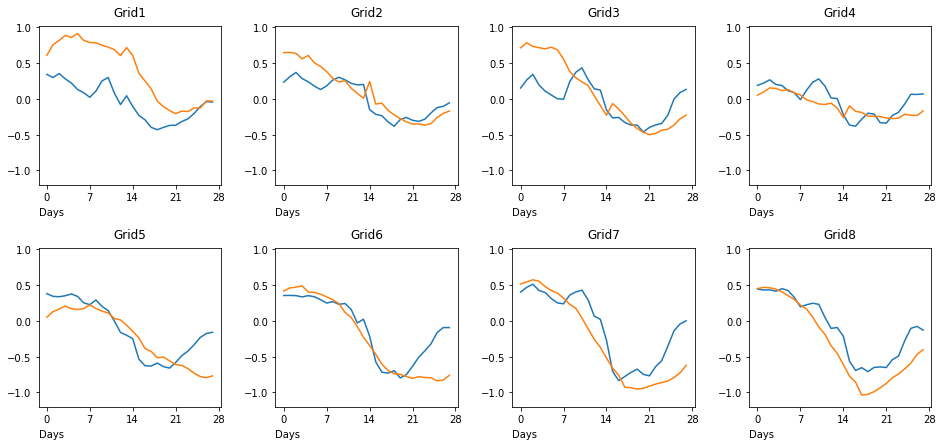

In [ ]:
# Bidirectional LSTM
plot_predictions(bilstm_model, X1_test, y1_test)

MSE =  0.33148831626538927
RMSE =  0.575750220378064
MAE =  0.4638882382735084


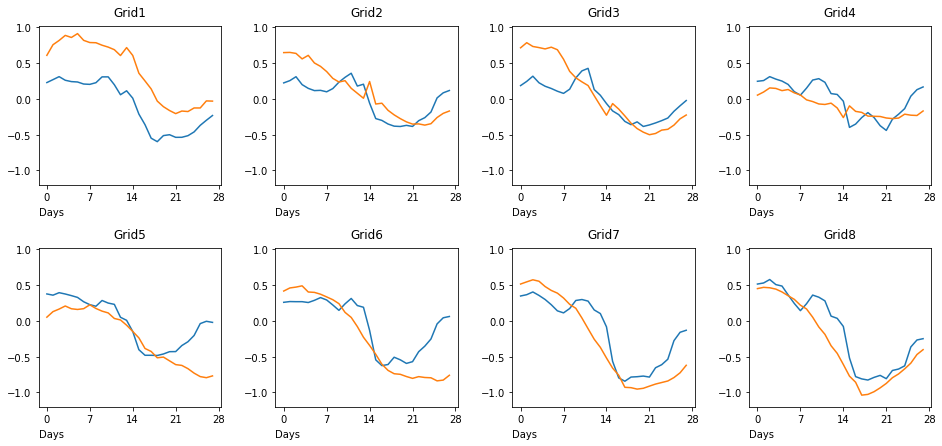

In [ ]:
# Stacked LSTM
plot_predictions(slstm_model, X1_test, y1_test)

MSE =  0.3135107666519719
RMSE =  0.559920321699411
MAE =  0.4550644547004019


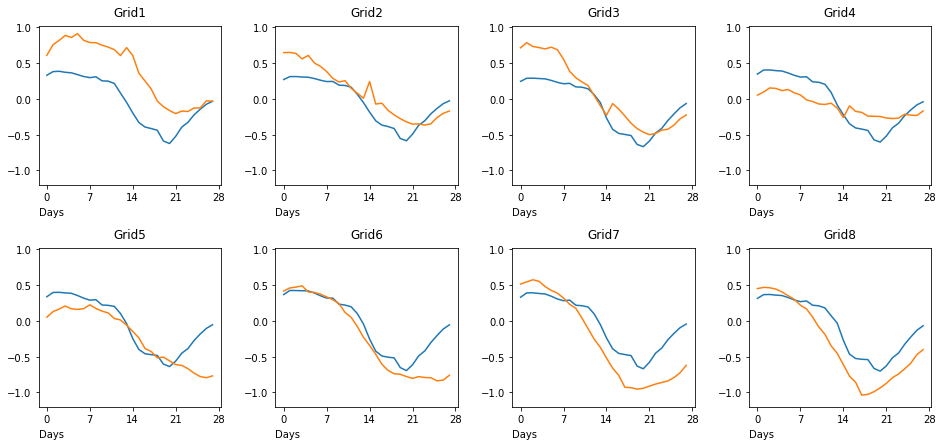

In [ ]:
# Bi + Stacked LSTM

plot_predictions(bislstm_model, X1_test, y1_test)

MSE =  0.30587077506916416
RMSE =  0.5530558516724727
MAE =  0.4431341154489291


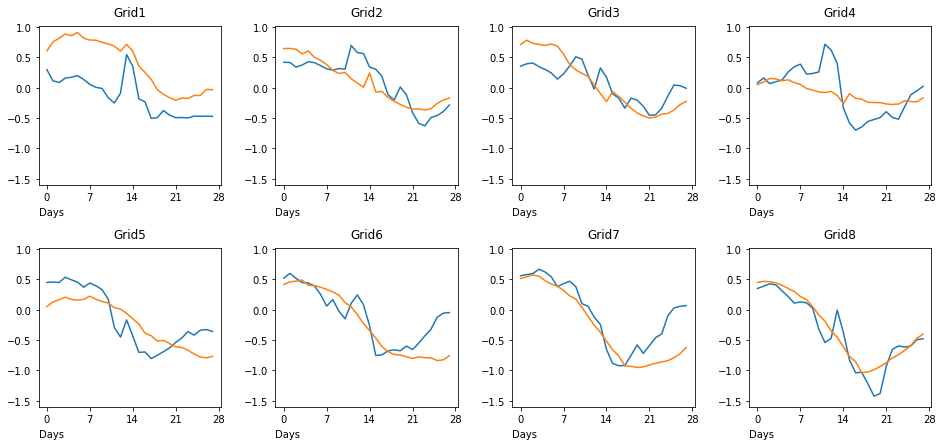

In [ ]:
# GRU
plot_predictions(gru_model, X1_test, y1_test)

MSE =  0.274244947500438
RMSE =  0.5236840149369064
MAE =  0.41889634909746315


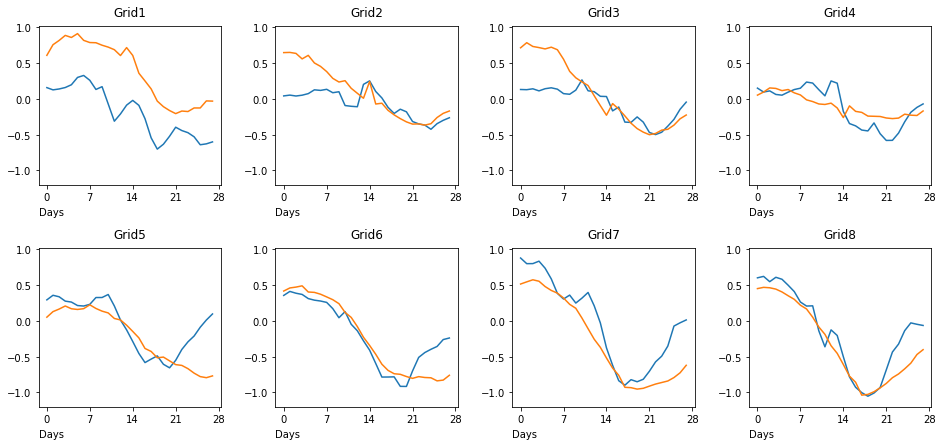

In [ ]:
# Bi GRU
plot_predictions(bigru_model, X1_test, y1_test)

MSE =  0.28228403221827036
RMSE =  0.5313040863933481
MAE =  0.42389016726138157


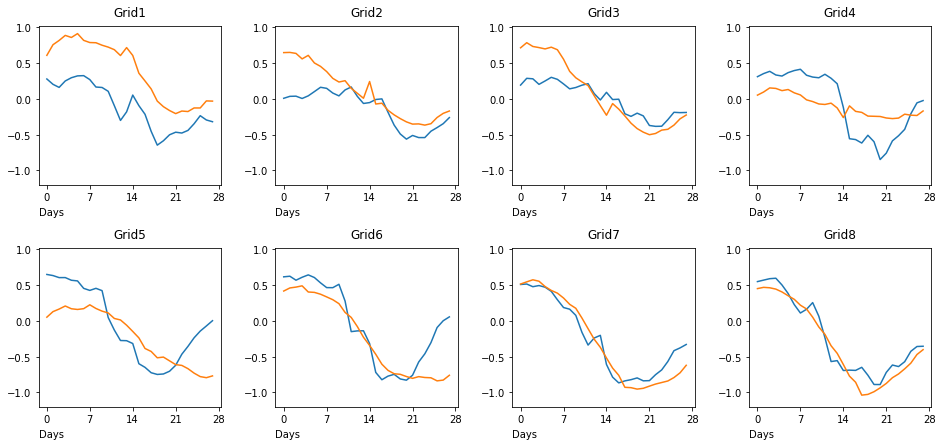

In [ ]:
# Stacked GRU
plot_predictions(sgru_model, X1_test, y1_test)

MSE =  0.24836436607669055
RMSE =  0.4983616819907912
MAE =  0.3960804711630511


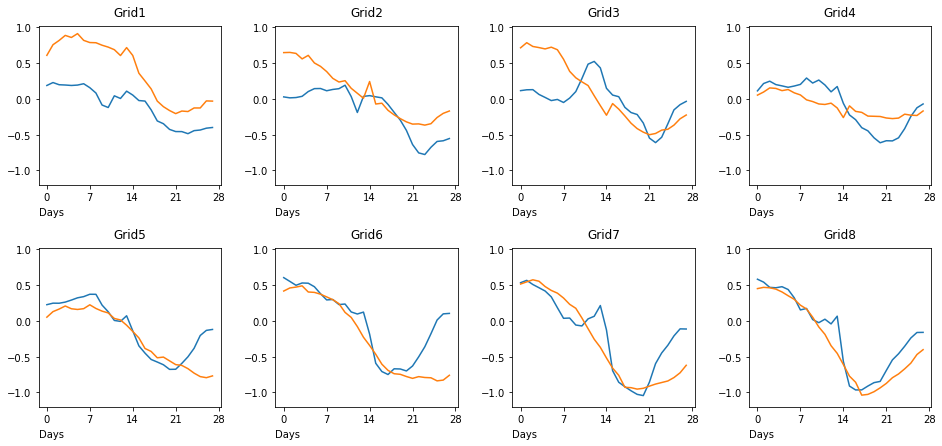

In [ ]:
# Bi + Stacked GRU

plot_predictions(bisgru_model, X1_test, y1_test)

MSE =  0.3914465141619596
RMSE =  0.6256568661510553
MAE =  0.4999980363698797


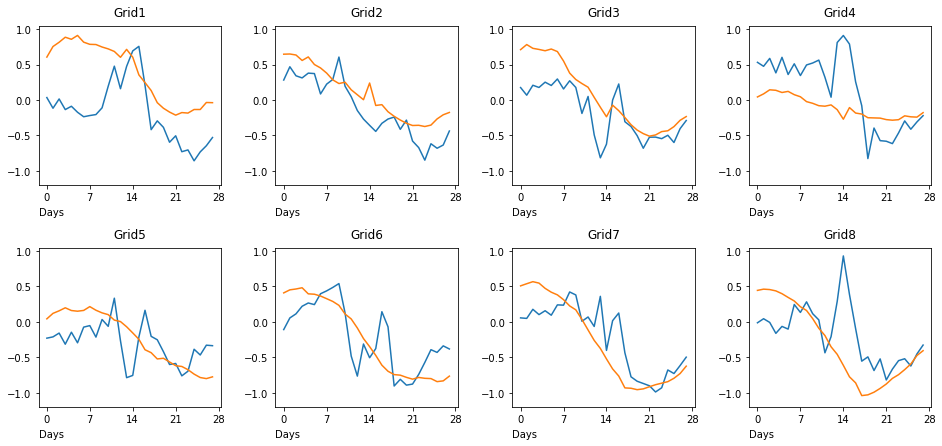

In [ ]:
# 1D CNN (kernel size = 4)
plot_predictions(cnn_k4_model, X2_test, y2_test)

MSE =  0.3659436459665948
RMSE =  0.6049327615252746
MAE =  0.4781627624893944


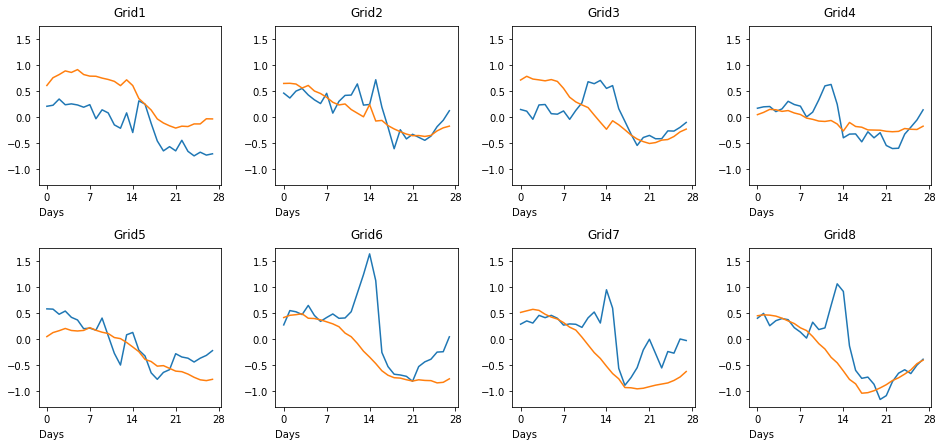

In [ ]:
# 1D CNN (kernel size = 2)
plot_predictions(cnn_k2_model, X3_test, y3_test)

### 2.2. Training and Testing with Attention Mechanism

In [24]:
# Attention layer

import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

##### **Vanilla LSTM + Attention**

In [ ]:
vlstm_att_model = Sequential()
vlstm_att_model.add(InputLayer((window_size, 937)))
vlstm_att_model.add(LSTM(640, return_sequences=True))
vlstm_att_model.add(attention())
vlstm_att_model.add(Dense(320, 'relu'))
vlstm_att_model.add(Dense(187, 'linear'))

vlstm_att_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 640)            4039680   
                                                                 
 attention_1 (attention)     (None, 640)               642       
                                                                 
 dense_26 (Dense)            (None, 320)               205120    
                                                                 
 dense_27 (Dense)            (None, 187)               60027     
                                                                 
Total params: 4,305,469
Trainable params: 4,305,469
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp7 = ModelCheckpoint('vlstm_att_model/', save_best_only=True)
lh7 = LossHistory()
vlstm_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
vlstm_att_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp7, lh7])
vlstm_att_model = load_model('vlstm_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8675 - root_mean_squared_error: 0.9314

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 9s 779ms/step - loss: 0.8675 - root_mean_squared_error: 0.9314 - val_loss: 0.3717 - val_root_mean_squared_error: 0.6097
Epoch 2/25
10/10 [==============================] - 4s 374ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933 - val_loss: 0.4478 - val_root_mean_squared_error: 0.6692
Epoch 3/25
10/10 [==============================] - 4s 362ms/step - loss: 0.4562 - root_mean_squared_error: 0.6754 - val_loss: 0.5024 - val_root_mean_squared_error: 0.7088
Epoch 4/25
10/10 [==============================] - 3s 352ms/step - loss: 0.3345 - root_mean_squared_error: 0.5783 - val_loss: 0.5217 - val_root_mean_squared_error: 0.7223
Epoch 5/25
10/10 [==============================] - 4s 377ms/step - loss: 0.2512 - root_mean_squared_error: 0.5012 - val_loss: 0.5010 - val_root_mean_squared_error: 0.7078
Epoch 6/25
10/10 [==============================] - 4s 358ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453 - val_loss: 0.4674 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 7s 784ms/step - loss: 0.1165 - root_mean_squared_error: 0.3414 - val_loss: 0.3503 - val_root_mean_squared_error: 0.5919
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.1053 - root_mean_squared_error: 0.3245

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 7s 747ms/step - loss: 0.1053 - root_mean_squared_error: 0.3245 - val_loss: 0.3340 - val_root_mean_squared_error: 0.5780
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0955 - root_mean_squared_error: 0.3091

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 7s 759ms/step - loss: 0.0955 - root_mean_squared_error: 0.3091 - val_loss: 0.3258 - val_root_mean_squared_error: 0.5708
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0870 - root_mean_squared_error: 0.2949

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0870 - root_mean_squared_error: 0.2949 - val_loss: 0.3179 - val_root_mean_squared_error: 0.5638
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0793 - root_mean_squared_error: 0.2816

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 7s 717ms/step - loss: 0.0793 - root_mean_squared_error: 0.2816 - val_loss: 0.3108 - val_root_mean_squared_error: 0.5575
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0726 - root_mean_squared_error: 0.2695

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 689ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695 - val_loss: 0.3041 - val_root_mean_squared_error: 0.5515
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0669 - root_mean_squared_error: 0.2586

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 687ms/step - loss: 0.0669 - root_mean_squared_error: 0.2586 - val_loss: 0.2999 - val_root_mean_squared_error: 0.5476
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0621 - root_mean_squared_error: 0.2491

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 7s 697ms/step - loss: 0.0621 - root_mean_squared_error: 0.2491 - val_loss: 0.2961 - val_root_mean_squared_error: 0.5441
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0577 - root_mean_squared_error: 0.2401

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 624ms/step - loss: 0.0577 - root_mean_squared_error: 0.2401 - val_loss: 0.2912 - val_root_mean_squared_error: 0.5396
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.2320

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 634ms/step - loss: 0.0538 - root_mean_squared_error: 0.2320 - val_loss: 0.2894 - val_root_mean_squared_error: 0.5380
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2246

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 619ms/step - loss: 0.0504 - root_mean_squared_error: 0.2246 - val_loss: 0.2874 - val_root_mean_squared_error: 0.5361
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0476 - root_mean_squared_error: 0.2181

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 603ms/step - loss: 0.0476 - root_mean_squared_error: 0.2181 - val_loss: 0.2822 - val_root_mean_squared_error: 0.5312
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0448 - root_mean_squared_error: 0.2116

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 7s 769ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.2768 - val_root_mean_squared_error: 0.5261
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0425 - root_mean_squared_error: 0.2061

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 643ms/step - loss: 0.0425 - root_mean_squared_error: 0.2061 - val_loss: 0.2721 - val_root_mean_squared_error: 0.5216
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0403 - root_mean_squared_error: 0.2007

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 5s 588ms/step - loss: 0.0403 - root_mean_squared_error: 0.2007 - val_loss: 0.2703 - val_root_mean_squared_error: 0.5199
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0383 - root_mean_squared_error: 0.1958

INFO:tensorflow:Assets written to: vlstm_att_model\assets


INFO:tensorflow:Assets written to: vlstm_att_model\assets


10/10 [==============================] - 6s 656ms/step - loss: 0.0383 - root_mean_squared_error: 0.1958 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5195


In [ ]:
bislstm_att_model = Sequential()
bislstm_att_model.add(InputLayer((window_size, 937)))
bislstm_att_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_att_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_att_model.add(LSTM(640, return_sequences=True))
bislstm_att_model.add(LSTM(640, return_sequences=True))
bislstm_att_model.add(attention())
bislstm_att_model.add(Dense(320, 'relu'))
bislstm_att_model.add(Dense(187, 'linear'))

bislstm_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 2, 1280)          8079360   
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 2, 1280)          9835520   
 onal)                                                           
                                                                 
 lstm_4 (LSTM)               (None, 2, 640)            4917760   
                                                                 
 lstm_5 (LSTM)               (None, 640)               3279360   
                                                                 
 dense_44 (Dense)            (None, 320)               205120    
                                                                 
 dense_45 (Dense)            (None, 187)             

In [ ]:
cp71 = ModelCheckpoint('bislstm_att_model/', save_best_only=True)
lh71 = LossHistory()
bislstm_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bislstm_att_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp71, lh71])
bislstm_att_model = load_model('bislstm_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9752 - root_mean_squared_error: 0.9875

INFO:tensorflow:Assets written to: bislstm_att_model\assets


INFO:tensorflow:Assets written to: bislstm_att_model\assets


10/10 [==============================] - 109s 10s/step - loss: 0.9752 - root_mean_squared_error: 0.9875 - val_loss: 0.3226 - val_root_mean_squared_error: 0.5680
Epoch 2/25
10/10 [==============================] - 46s 5s/step - loss: 0.9038 - root_mean_squared_error: 0.9507 - val_loss: 0.3450 - val_root_mean_squared_error: 0.5874
Epoch 3/25
10/10 [==============================] - 47s 5s/step - loss: 0.6772 - root_mean_squared_error: 0.8229 - val_loss: 0.5974 - val_root_mean_squared_error: 0.7729
Epoch 4/25
10/10 [==============================] - 46s 5s/step - loss: 0.4708 - root_mean_squared_error: 0.6862 - val_loss: 0.9059 - val_root_mean_squared_error: 0.9518
Epoch 5/25
10/10 [==============================] - 46s 5s/step - loss: 0.3380 - root_mean_squared_error: 0.5813 - val_loss: 0.5480 - val_root_mean_squared_error: 0.7402
Epoch 6/25
10/10 [==============================] - 46s 5s/step - loss: 0.2677 - root_mean_squared_error: 0.5174 - val_loss: 0.3596 - val_root_mean_squared_err

INFO:tensorflow:Assets written to: bislstm_att_model\assets


INFO:tensorflow:Assets written to: bislstm_att_model\assets


10/10 [==============================] - 78s 8s/step - loss: 0.2343 - root_mean_squared_error: 0.4841 - val_loss: 0.2850 - val_root_mean_squared_error: 0.5338
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.2146 - root_mean_squared_error: 0.4633

INFO:tensorflow:Assets written to: bislstm_att_model\assets


INFO:tensorflow:Assets written to: bislstm_att_model\assets


10/10 [==============================] - 76s 8s/step - loss: 0.2146 - root_mean_squared_error: 0.4633 - val_loss: 0.2675 - val_root_mean_squared_error: 0.5172
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1993 - root_mean_squared_error: 0.4464

INFO:tensorflow:Assets written to: bislstm_att_model\assets


INFO:tensorflow:Assets written to: bislstm_att_model\assets


10/10 [==============================] - 74s 8s/step - loss: 0.1993 - root_mean_squared_error: 0.4464 - val_loss: 0.2626 - val_root_mean_squared_error: 0.5125
Epoch 10/25
10/10 [==============================] - 47s 5s/step - loss: 0.1880 - root_mean_squared_error: 0.4336 - val_loss: 0.2657 - val_root_mean_squared_error: 0.5155
Epoch 11/25
10/10 [==============================] - 45s 5s/step - loss: 0.1818 - root_mean_squared_error: 0.4263 - val_loss: 0.2704 - val_root_mean_squared_error: 0.5200
Epoch 12/25
10/10 [==============================] - 45s 5s/step - loss: 0.1770 - root_mean_squared_error: 0.4208 - val_loss: 0.2719 - val_root_mean_squared_error: 0.5215
Epoch 13/25
10/10 [==============================] - 46s 5s/step - loss: 0.1718 - root_mean_squared_error: 0.4145 - val_loss: 0.2720 - val_root_mean_squared_error: 0.5215
Epoch 14/25
10/10 [==============================] - 46s 5s/step - loss: 0.1648 - root_mean_squared_error: 0.4059 - val_loss: 0.2742 - val_root_mean_squared_

##### **GRU + Attention**

In [ ]:
gru_att_model = Sequential()
gru_att_model.add(InputLayer((window_size, 937)))
gru_att_model.add(GRU(640, return_sequences=True))
gru_att_model.add(attention())
gru_att_model.add(Dense(320, 'relu'))
gru_att_model.add(Dense(187, 'linear'))

gru_att_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 2, 640)            3031680   
                                                                 
 attention_2 (attention)     (None, 640)               642       
                                                                 
 dense_28 (Dense)            (None, 320)               205120    
                                                                 
 dense_29 (Dense)            (None, 187)               60027     
                                                                 
Total params: 3,297,469
Trainable params: 3,297,469
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp8 = ModelCheckpoint('gru_att_model/', save_best_only=True)
lh8 = LossHistory()
gru_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
gru_att_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp8, lh8])
gru_att_model = load_model('gru_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8268 - root_mean_squared_error: 0.9093

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 7s 535ms/step - loss: 0.8268 - root_mean_squared_error: 0.9093 - val_loss: 0.3955 - val_root_mean_squared_error: 0.6289
Epoch 2/25
10/10 [==============================] - 2s 207ms/step - loss: 0.5521 - root_mean_squared_error: 0.7430 - val_loss: 0.4740 - val_root_mean_squared_error: 0.6885
Epoch 3/25
10/10 [==============================] - 2s 196ms/step - loss: 0.4015 - root_mean_squared_error: 0.6336 - val_loss: 0.5107 - val_root_mean_squared_error: 0.7147
Epoch 4/25
10/10 [==============================] - 2s 185ms/step - loss: 0.2957 - root_mean_squared_error: 0.5438 - val_loss: 0.5088 - val_root_mean_squared_error: 0.7133
Epoch 5/25
10/10 [==============================] - 2s 180ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730 - val_loss: 0.4791 - val_root_mean_squared_error: 0.6921
Epoch 6/25
10/10 [==============================] - 2s 184ms/step - loss: 0.1785 - root_mean_squared_error: 0.4225 - val_loss: 0.4378 - val_root_mean_s

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 511ms/step - loss: 0.1510 - root_mean_squared_error: 0.3886 - val_loss: 0.3944 - val_root_mean_squared_error: 0.6280
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1321 - root_mean_squared_error: 0.3635

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 531ms/step - loss: 0.1321 - root_mean_squared_error: 0.3635 - val_loss: 0.3551 - val_root_mean_squared_error: 0.5959
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3439

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 568ms/step - loss: 0.1182 - root_mean_squared_error: 0.3439 - val_loss: 0.3289 - val_root_mean_squared_error: 0.5735
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1068 - root_mean_squared_error: 0.3268

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 500ms/step - loss: 0.1068 - root_mean_squared_error: 0.3268 - val_loss: 0.3103 - val_root_mean_squared_error: 0.5571
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0964 - root_mean_squared_error: 0.3104

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 498ms/step - loss: 0.0964 - root_mean_squared_error: 0.3104 - val_loss: 0.2953 - val_root_mean_squared_error: 0.5434
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0877 - root_mean_squared_error: 0.2961

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 497ms/step - loss: 0.0877 - root_mean_squared_error: 0.2961 - val_loss: 0.2834 - val_root_mean_squared_error: 0.5323
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0803 - root_mean_squared_error: 0.2834

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 505ms/step - loss: 0.0803 - root_mean_squared_error: 0.2834 - val_loss: 0.2749 - val_root_mean_squared_error: 0.5243
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0736 - root_mean_squared_error: 0.2713

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 577ms/step - loss: 0.0736 - root_mean_squared_error: 0.2713 - val_loss: 0.2652 - val_root_mean_squared_error: 0.5150
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0678 - root_mean_squared_error: 0.2604

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 510ms/step - loss: 0.0678 - root_mean_squared_error: 0.2604 - val_loss: 0.2567 - val_root_mean_squared_error: 0.5066
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0628 - root_mean_squared_error: 0.2507

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 495ms/step - loss: 0.0628 - root_mean_squared_error: 0.2507 - val_loss: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0583 - root_mean_squared_error: 0.2414

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 499ms/step - loss: 0.0583 - root_mean_squared_error: 0.2414 - val_loss: 0.2442 - val_root_mean_squared_error: 0.4941
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0547 - root_mean_squared_error: 0.2339

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 497ms/step - loss: 0.0547 - root_mean_squared_error: 0.2339 - val_loss: 0.2367 - val_root_mean_squared_error: 0.4865
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.2260

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 591ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.2308 - val_root_mean_squared_error: 0.4805
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.2195

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 502ms/step - loss: 0.0482 - root_mean_squared_error: 0.2195 - val_loss: 0.2248 - val_root_mean_squared_error: 0.4741
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.2134

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 499ms/step - loss: 0.0455 - root_mean_squared_error: 0.2134 - val_loss: 0.2211 - val_root_mean_squared_error: 0.4702
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2074

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 502ms/step - loss: 0.0430 - root_mean_squared_error: 0.2074 - val_loss: 0.2159 - val_root_mean_squared_error: 0.4647
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.2019

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 495ms/step - loss: 0.0408 - root_mean_squared_error: 0.2019 - val_loss: 0.2124 - val_root_mean_squared_error: 0.4609
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0388 - root_mean_squared_error: 0.1969

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 496ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.2075 - val_root_mean_squared_error: 0.4555
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0372 - root_mean_squared_error: 0.1928

INFO:tensorflow:Assets written to: gru_att_model\assets


INFO:tensorflow:Assets written to: gru_att_model\assets


10/10 [==============================] - 5s 591ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.2037 - val_root_mean_squared_error: 0.4513


In [ ]:
gru_att_model2 = Sequential()
gru_att_model2.add(InputLayer((window_size, 937)))
gru_att_model2.add(Bidirectional(GRU(640, return_sequences=True)))
gru_att_model2.add(Bidirectional(GRU(640, return_sequences=True)))
gru_att_model2.add(GRU(640, return_sequences=True))
gru_att_model2.add(GRU(640, return_sequences=True))
gru_att_model2.add(attention())
gru_att_model2.add(Dense(320, 'relu'))
gru_att_model2.add(Dense(187, 'linear'))


gru_att_model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 2, 1280)          6063360   
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 2, 1280)          7380480   
 nal)                                                            
                                                                 
 gru_25 (GRU)                (None, 2, 640)            3690240   
                                                                 
 gru_26 (GRU)                (None, 2, 640)            2461440   
                                                                 
 attention_5 (attention)     (None, 640)               642       
                                                                 
 dense_36 (Dense)            (None, 320)             

In [ ]:
cp81 = ModelCheckpoint('gru_att_model2/', save_best_only=True)
lh81 = LossHistory()
gru_att_model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
gru_att_model2.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp81, lh81])
gru_att_model2 = load_model('gru_att_model2/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8685 - root_mean_squared_error: 0.9319

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 117s 10s/step - loss: 0.8685 - root_mean_squared_error: 0.9319 - val_loss: 0.4327 - val_root_mean_squared_error: 0.6578
Epoch 2/25
10/10 [==============================] - 49s 5s/step - loss: 0.5916 - root_mean_squared_error: 0.7692 - val_loss: 0.7646 - val_root_mean_squared_error: 0.8744
Epoch 3/25
10/10 [==============================] - 52s 5s/step - loss: 0.4185 - root_mean_squared_error: 0.6469 - val_loss: 0.4872 - val_root_mean_squared_error: 0.6980
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.3003 - root_mean_squared_error: 0.5480

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 111s 12s/step - loss: 0.3003 - root_mean_squared_error: 0.5480 - val_loss: 0.2913 - val_root_mean_squared_error: 0.5398
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2262 - root_mean_squared_error: 0.4756

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 120s 13s/step - loss: 0.2262 - root_mean_squared_error: 0.4756 - val_loss: 0.2540 - val_root_mean_squared_error: 0.5040
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1816 - root_mean_squared_error: 0.4262

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 70s 7s/step - loss: 0.1816 - root_mean_squared_error: 0.4262 - val_loss: 0.2522 - val_root_mean_squared_error: 0.5022
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1537 - root_mean_squared_error: 0.3920

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 68s 7s/step - loss: 0.1537 - root_mean_squared_error: 0.3920 - val_loss: 0.2509 - val_root_mean_squared_error: 0.5009
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1343 - root_mean_squared_error: 0.3665

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 63s 7s/step - loss: 0.1343 - root_mean_squared_error: 0.3665 - val_loss: 0.2495 - val_root_mean_squared_error: 0.4995
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1195 - root_mean_squared_error: 0.3457

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 65s 7s/step - loss: 0.1195 - root_mean_squared_error: 0.3457 - val_loss: 0.2491 - val_root_mean_squared_error: 0.4991
Epoch 10/25
10/10 [==============================] - 42s 4s/step - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.2540 - val_root_mean_squared_error: 0.5040
Epoch 11/25
10/10 [==============================] - 39s 4s/step - loss: 0.0979 - root_mean_squared_error: 0.3130 - val_loss: 0.2528 - val_root_mean_squared_error: 0.5027
Epoch 12/25
10/10 [==============================] - 43s 4s/step - loss: 0.0888 - root_mean_squared_error: 0.2979 - val_loss: 0.2538 - val_root_mean_squared_error: 0.5038
Epoch 13/25
10/10 [==============================] - 42s 4s/step - loss: 0.0810 - root_mean_squared_error: 0.2845 - val_loss: 0.2520 - val_root_mean_squared_error: 0.5020
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0738 - root_mean_squared_error: 0.2717

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 60s 6s/step - loss: 0.0738 - root_mean_squared_error: 0.2717 - val_loss: 0.2478 - val_root_mean_squared_error: 0.4978
Epoch 15/25
10/10 [==============================] - 39s 4s/step - loss: 0.0685 - root_mean_squared_error: 0.2617 - val_loss: 0.2479 - val_root_mean_squared_error: 0.4979
Epoch 16/25
10/10 [==============================] - 41s 4s/step - loss: 0.0630 - root_mean_squared_error: 0.2511 - val_loss: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0588 - root_mean_squared_error: 0.2425

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 67s 7s/step - loss: 0.0588 - root_mean_squared_error: 0.2425 - val_loss: 0.2432 - val_root_mean_squared_error: 0.4932
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0547 - root_mean_squared_error: 0.2339

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 67s 7s/step - loss: 0.0547 - root_mean_squared_error: 0.2339 - val_loss: 0.2425 - val_root_mean_squared_error: 0.4925
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0512 - root_mean_squared_error: 0.2264

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 66s 7s/step - loss: 0.0512 - root_mean_squared_error: 0.2264 - val_loss: 0.2372 - val_root_mean_squared_error: 0.4870
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0484 - root_mean_squared_error: 0.2199

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 64s 7s/step - loss: 0.0484 - root_mean_squared_error: 0.2199 - val_loss: 0.2344 - val_root_mean_squared_error: 0.4841
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0457 - root_mean_squared_error: 0.2138

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 64s 7s/step - loss: 0.0457 - root_mean_squared_error: 0.2138 - val_loss: 0.2300 - val_root_mean_squared_error: 0.4796
Epoch 22/25
10/10 [==============================] - 45s 5s/step - loss: 0.0433 - root_mean_squared_error: 0.2080 - val_loss: 0.2307 - val_root_mean_squared_error: 0.4803
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0410 - root_mean_squared_error: 0.2024

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 65s 7s/step - loss: 0.0410 - root_mean_squared_error: 0.2024 - val_loss: 0.2248 - val_root_mean_squared_error: 0.4741
Epoch 24/25
10/10 [==============================] - 47s 5s/step - loss: 0.0388 - root_mean_squared_error: 0.1971 - val_loss: 0.2250 - val_root_mean_squared_error: 0.4743
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0371 - root_mean_squared_error: 0.1927

INFO:tensorflow:Assets written to: gru_att_model2\assets


INFO:tensorflow:Assets written to: gru_att_model2\assets


10/10 [==============================] - 69s 7s/step - loss: 0.0371 - root_mean_squared_error: 0.1927 - val_loss: 0.2192 - val_root_mean_squared_error: 0.4681


##### **1D CNN** *(kernel size = 2)* **+ Attention**

In [ ]:
cnn_k2_att_model = Sequential()
cnn_k2_att_model.add(InputLayer((window_size3, 937)))
cnn_k2_att_model.add(Conv1D(640, kernel_size=2, activation='relu'))
cnn_k2_att_model.add(attention())
cnn_k2_att_model.add(Dense(320, 'relu'))
cnn_k2_att_model.add(Dense(187, 'linear'))

cnn_k2_att_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 3, 640)            1200000   
                                                                 
 attention_3 (attention)     (None, 640)               643       
                                                                 
 dense_30 (Dense)            (None, 320)               205120    
                                                                 
 dense_31 (Dense)            (None, 187)               60027     
                                                                 
Total params: 1,465,790
Trainable params: 1,465,790
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp9 = ModelCheckpoint('cnn_k2_att_model/', save_best_only=True)
lh9 = LossHistory()
cnn_k2_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
cnn_k2_att_model.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=25, callbacks=[cp9, lh9])
cnn_k2_att_model = load_model('cnn_k2_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9441 - root_mean_squared_error: 0.9716INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 169ms/step - loss: 0.9441 - root_mean_squared_error: 0.9716 - val_loss: 0.5164 - val_root_mean_squared_error: 0.7186
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.5799 - root_mean_squared_error: 0.7615INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 175ms/step - loss: 0.5799 - root_mean_squared_error: 0.7615 - val_loss: 0.4985 - val_root_mean_squared_error: 0.7060
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.4152 - root_mean_squared_error: 0.6444INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 155ms/step - loss: 0.4152 - root_mean_squared_error: 0.6444 - val_loss: 0.4834 - val_root_mean_squared_error: 0.6953
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.3039 - root_mean_squared_error: 0.5513INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 155ms/step - loss: 0.3039 - root_mean_squared_error: 0.5513 - val_loss: 0.4764 - val_root_mean_squared_error: 0.6902
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2280 - root_mean_squared_error: 0.4775INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 170ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775 - val_loss: 0.4637 - val_root_mean_squared_error: 0.6810
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1789 - root_mean_squared_error: 0.4229INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 165ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229 - val_loss: 0.4386 - val_root_mean_squared_error: 0.6622
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1496 - root_mean_squared_error: 0.3868INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 187ms/step - loss: 0.1496 - root_mean_squared_error: 0.3868 - val_loss: 0.4193 - val_root_mean_squared_error: 0.6475
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1309 - root_mean_squared_error: 0.3617INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 158ms/step - loss: 0.1309 - root_mean_squared_error: 0.3617 - val_loss: 0.3955 - val_root_mean_squared_error: 0.6289
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1170 - root_mean_squared_error: 0.3421INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 174ms/step - loss: 0.1170 - root_mean_squared_error: 0.3421 - val_loss: 0.3752 - val_root_mean_squared_error: 0.6125
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1061 - root_mean_squared_error: 0.3257INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 165ms/step - loss: 0.1061 - root_mean_squared_error: 0.3257 - val_loss: 0.3608 - val_root_mean_squared_error: 0.6006
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0971 - root_mean_squared_error: 0.3115INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 158ms/step - loss: 0.0971 - root_mean_squared_error: 0.3115 - val_loss: 0.3435 - val_root_mean_squared_error: 0.5861
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0887 - root_mean_squared_error: 0.2978INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 144ms/step - loss: 0.0887 - root_mean_squared_error: 0.2978 - val_loss: 0.3354 - val_root_mean_squared_error: 0.5792
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0819 - root_mean_squared_error: 0.2862INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 148ms/step - loss: 0.0819 - root_mean_squared_error: 0.2862 - val_loss: 0.3227 - val_root_mean_squared_error: 0.5680
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0757 - root_mean_squared_error: 0.2751INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 150ms/step - loss: 0.0757 - root_mean_squared_error: 0.2751 - val_loss: 0.3144 - val_root_mean_squared_error: 0.5607
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0701 - root_mean_squared_error: 0.2648INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 240ms/step - loss: 0.0701 - root_mean_squared_error: 0.2648 - val_loss: 0.3084 - val_root_mean_squared_error: 0.5554
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0650 - root_mean_squared_error: 0.2549INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 147ms/step - loss: 0.0650 - root_mean_squared_error: 0.2549 - val_loss: 0.3031 - val_root_mean_squared_error: 0.5506
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0608 - root_mean_squared_error: 0.2465INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 142ms/step - loss: 0.0608 - root_mean_squared_error: 0.2465 - val_loss: 0.2970 - val_root_mean_squared_error: 0.5450
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0571 - root_mean_squared_error: 0.2390INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 148ms/step - loss: 0.0571 - root_mean_squared_error: 0.2390 - val_loss: 0.2905 - val_root_mean_squared_error: 0.5390
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0536 - root_mean_squared_error: 0.2315INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 149ms/step - loss: 0.0536 - root_mean_squared_error: 0.2315 - val_loss: 0.2858 - val_root_mean_squared_error: 0.5346
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0508 - root_mean_squared_error: 0.2254INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 179ms/step - loss: 0.0508 - root_mean_squared_error: 0.2254 - val_loss: 0.2818 - val_root_mean_squared_error: 0.5309
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.2193INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 179ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193 - val_loss: 0.2780 - val_root_mean_squared_error: 0.5272
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.2131INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 190ms/step - loss: 0.0454 - root_mean_squared_error: 0.2131 - val_loss: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2073INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 161ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.2693 - val_root_mean_squared_error: 0.5189
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0410 - root_mean_squared_error: 0.2026INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 153ms/step - loss: 0.0410 - root_mean_squared_error: 0.2026 - val_loss: 0.2671 - val_root_mean_squared_error: 0.5168
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0393 - root_mean_squared_error: 0.1982INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 184ms/step - loss: 0.0393 - root_mean_squared_error: 0.1982 - val_loss: 0.2632 - val_root_mean_squared_error: 0.5130


##### **Predictions**

MSE =  0.32247400863461206
RMSE =  0.5678679499977192
MAE =  0.46137824014939804


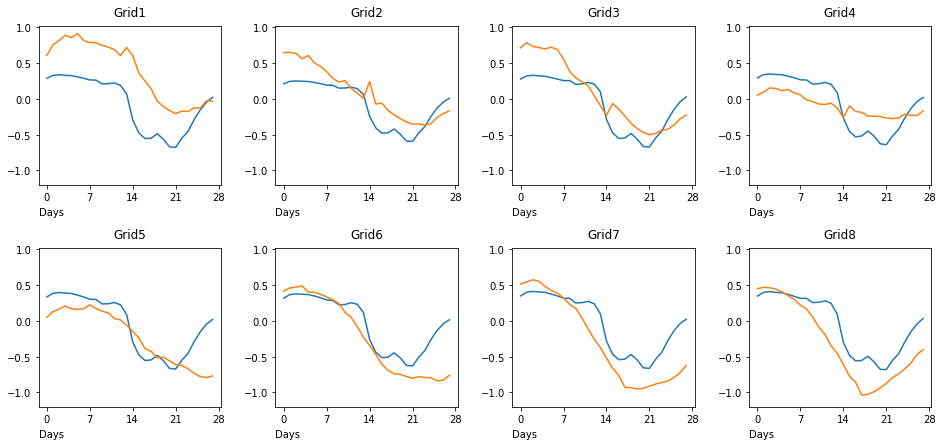

In [ ]:
# Bi + Stacked LSTM + Attention
plot_predictions(bislstm_att_model, X1_test, y1_test)

MSE =  0.2925652182033847
RMSE =  0.540892982209406
MAE =  0.4331230477325594


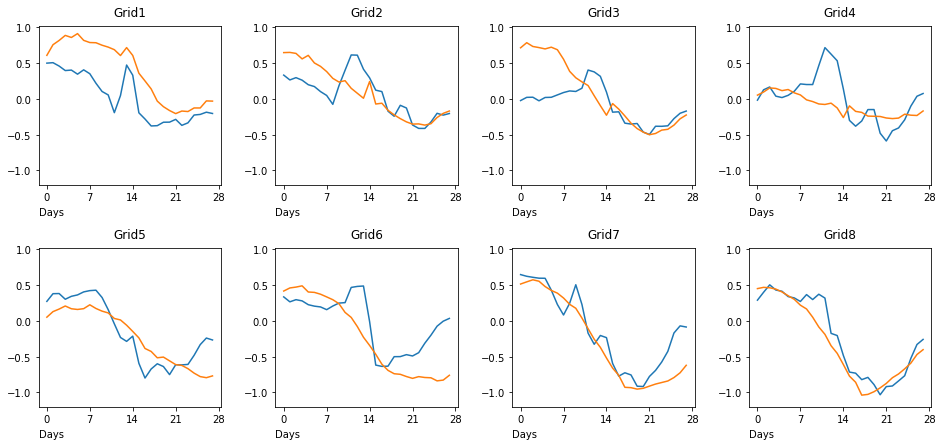

In [ ]:
# GRU + Attention
plot_predictions(gru_att_model, X1_test, y1_test)

MSE =  0.3490412194687524
RMSE =  0.5907971051628066
MAE =  0.4719694792639414


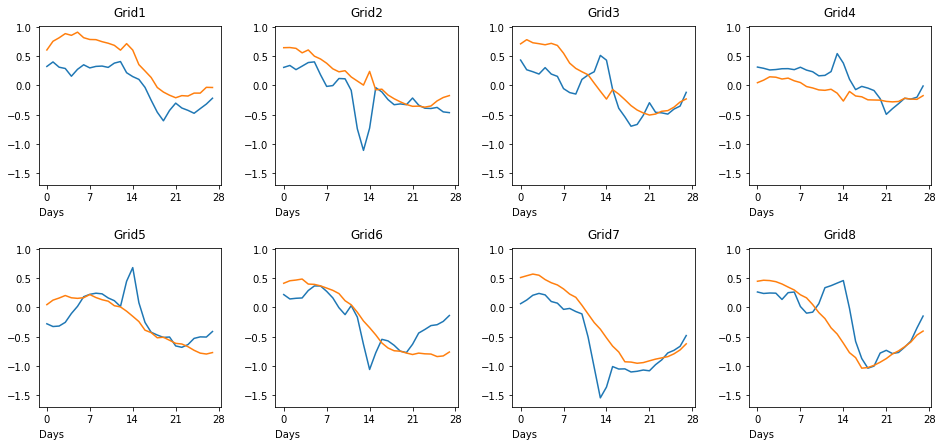

In [ ]:
# 1D Conv + Attention
plot_predictions(cnn_k2_att_model, X3_test, y3_test)

MSE =  0.276496296136997
RMSE =  0.5258291510909194
MAE =  0.42277020245688357


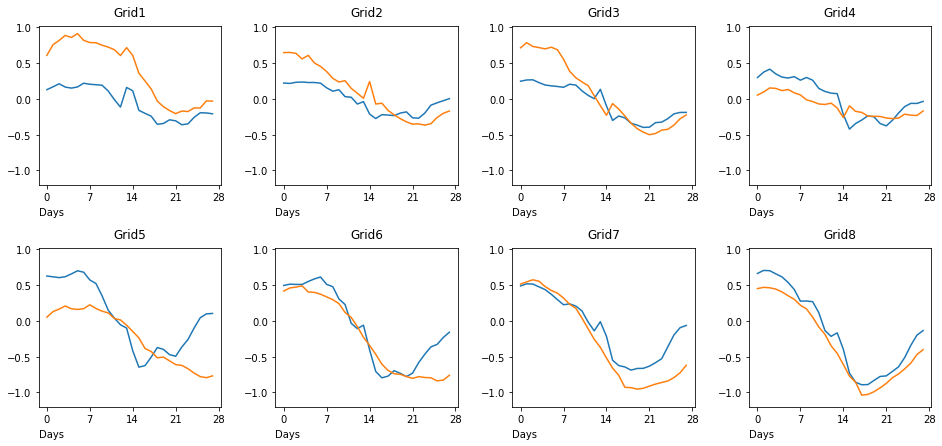

In [ ]:
plot_predictions(gru_att_model2, X1_test, y1_test)

### Trying different layer sizes

In [25]:
GRU_sizes = [1280, 2560] #, 3840
Dense0_sizes = [960, 1920] #, 2560      # GRU_sizes = [640, 960, 1280, 1920, 2560]
Dense1_sizes = [640, 1280] #640,     # Dense0_sizes = [320, 640, 960, 1280, 1920]
Dense2_sizes = [480, 640, 960]  #, 1280     # Dense1_sizes = [320, 640, 960, 1280]
Dense3_sizes = [320, 640]
Dense4_size = 320
Dense5_size = 187 

GRU_shape = []
Dense0_shape = []
Dense1_shape = []
Dense2_shape = []
Dense3_shape = []
Dense4_shape = []
MSEs = []


for z1 in range(len(GRU_sizes)):
    for z2 in range(len(Dense0_sizes)):
        if Dense0_sizes[z2] < GRU_sizes[z1]:
            for z3 in range(len(Dense1_sizes)):
                if Dense1_sizes[z3] < Dense0_sizes[z2]:
                    for z4 in range(len(Dense2_sizes)):
                        if Dense2_sizes[z4] < Dense1_sizes[z3]:

                            gru_ds_model = Sequential()
                            gru_ds_model.add(InputLayer((window_size, 937)))
                            gru_ds_model.add(Bidirectional(GRU(GRU_sizes[z1], return_sequences=True)))
                            gru_ds_model.add(Bidirectional(GRU(GRU_sizes[z1], return_sequences=True)))
                            gru_ds_model.add(GRU(GRU_sizes[z1], return_sequences=True))
                            gru_ds_model.add(GRU(GRU_sizes[z1]))
                            GRU_shape.append(GRU_sizes[z1])
                            gru_ds_model.add(Dense(Dense0_sizes[z2], 'relu'))
                            Dense0_shape.append(Dense0_sizes[z2])
                            gru_ds_model.add(Dense(Dense1_sizes[z3], 'relu'))
                            Dense1_shape.append(Dense1_sizes[z3])
                            gru_ds_model.add(Dense(Dense2_sizes[z4], 'relu'))
                            Dense2_shape.append(Dense2_sizes[z4])

                            if Dense2_sizes[z3] == 480:
                                gru_ds_model.add(Dense(Dense3_sizes[0], 'relu'))
                                Dense3_shape.append(Dense3_sizes[0])
                                Dense4_shape.append(np.NaN)
                            if Dense2_sizes[z3] == 640:
                                gru_ds_model.add(Dense(Dense3_sizes[0], 'relu'))
                                Dense3_shape.append(Dense3_sizes[0])
                                Dense4_shape.append(np.NaN)
                            if Dense2_sizes[z3] == 960:
                                gru_ds_model.add(Dense(Dense3_sizes[1], 'relu'))
                                for i in range(2):
                                    if i == 0:
                                        Dense4_shape.append(np.NaN)
                                    if i == 1:
                                        gru_ds_model.add(Dense(Dense4_size, 'relu'))
                                        Dense4_shape.append(Dense4_size)

                            gru_ds_model.add(Dense(Dense5_size, 'linear'))

                            cp10 = ModelCheckpoint('gru_ds_model/', save_best_only=True)
                            gru_ds_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
                            gru_ds_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, verbose = 0, callbacks=[cp10])
                            gru_ds_model = load_model('gru_ds_model/')

                            predictions = gru_ds_model.predict(X1_test).flatten()
                            MSEs.append(mse(y1_test.flatten(), predictions))

INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


KeyboardInterrupt: 

In [ ]:
print('OPTIMAL PARAMETERS:')

print('GRU size: ', str(GRU_shape[MSEs.index(min(MSEs))]))
print('Dense0 size: ', str(Dense0_shape[MSEs.index(min(MSEs))]))
print('Dense1 size: ', str(Dense1_shape[MSEs.index(min(MSEs))]))
print('Dense2 size: ', str(Dense2_shape[MSEs.index(min(MSEs))]))
print('Dense3 size: ', str(Dense3_shape[MSEs.index(min(MSEs))]))
print('Dense4 size: ', str(Dense4_shape[MSEs.index(min(MSEs))]))
print('Min MSE = ', str(min(MSEs)))
print()

print('WORST PARAMETERS:')

print('GRU size: ', str(GRU_shape[MSEs.index(max(MSEs))]))
print('Dense0 size: ', str(Dense0_shape[MSEs.index(max(MSEs))]))
print('Dense1 size: ', str(Dense1_shape[MSEs.index(max(MSEs))]))
print('Dense2 size: ', str(Dense2_shape[MSEs.index(max(MSEs))]))
print('Dense3 size: ', str(Dense3_shape[MSEs.index(max(MSEs))]))
print('Dense4 size: ', str(Dense4_shape[MSEs.index(max(MSEs))]))
print('MAX MSE = ', str(max(MSEs)))
print()

print('Mean MSE = ', str(np.mean(MSEs)))

OPTIMAL PARAMETERS:


ValueError: min() arg is an empty sequence

# Video work

In [25]:
gru_vid_model = Sequential()
gru_vid_model.add(InputLayer((window_size, 937)))
gru_vid_model.add(GRU(GRU_shape[MSEs.index(min(MSEs))]))
gru_vid_model.add(Dense(Dense0_shape[MSEs.index(min(MSEs))], 'relu'))
gru_vid_model.add(Dense(Dense1_shape[MSEs.index(min(MSEs))], 'relu'))
gru_vid_model.add(Dense(Dense2_shape[MSEs.index(min(MSEs))], 'relu'))
gru_vid_model.add(Dense(Dense3_shape[MSEs.index(min(MSEs))], 'relu'))
if Dense4_shape[MSEs.index(min(MSEs))] != np.NaN:
    gru_vid_model.add(Dense(Dense4_shape[MSEs.index(min(MSEs))], 'relu'))
gru_vid_model.add(Dense(187, 'linear'))

gru_vid_model.summary()

NameError: name 'GRU_shape' is not defined

In [48]:
gru_vid_model = Sequential()
gru_vid_model.add(InputLayer((window_size, 937)))
#gru_vid_model.add(Bidirectional(GRU(2560, return_sequences=True)))     ##
#gru_vid_model.add(Bidirectional(GRU(2560, return_sequences=True)))     ##
#gru_vid_model.add(GRU(1920, return_sequences=True))
gru_vid_model.add(GRU(3560))
#gru_vid_model.add(Dense(2240, 'relu'))
gru_vid_model.add(Dense(1980, 'relu'))
# gru_vid_model.add(Dense(960, 'relu'))
gru_vid_model.add(Dense(960, 'relu'))
gru_vid_model.add(Dense(480, 'relu'))
gru_vid_model.add(Dense(187, 'linear'))

gru_vid_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 3560)              48049320  
                                                                 
 dense_14 (Dense)            (None, 1980)              7050780   
                                                                 
 dense_15 (Dense)            (None, 960)               1901760   
                                                                 
 dense_16 (Dense)            (None, 480)               461280    
                                                                 
 dense_17 (Dense)            (None, 187)               89947     
                                                                 
Total params: 57,553,087
Trainable params: 57,553,087
Non-trainable params: 0
_________________________________________________________________


In [49]:
cp_vid = ModelCheckpoint('gru_vid_model/', save_best_only=True)
gru_vid_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
gru_vid_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=75, callbacks=[cp_vid])
gru_vid_model = load_model('gru_vid_model/')

Epoch 1/75
10/10 [==============================] - ETA: 0s - loss: 0.6562 - root_mean_squared_error: 0.8100

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 28s 3s/step - loss: 0.6562 - root_mean_squared_error: 0.8100 - val_loss: 0.4463 - val_root_mean_squared_error: 0.6680
Epoch 2/75
10/10 [==============================] - ETA: 0s - loss: 0.2852 - root_mean_squared_error: 0.5340

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.2852 - root_mean_squared_error: 0.5340 - val_loss: 0.4085 - val_root_mean_squared_error: 0.6391
Epoch 3/75
10/10 [==============================] - ETA: 0s - loss: 0.1580 - root_mean_squared_error: 0.3975

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.1580 - root_mean_squared_error: 0.3975 - val_loss: 0.3263 - val_root_mean_squared_error: 0.5712
Epoch 4/75
10/10 [==============================] - ETA: 0s - loss: 0.1110 - root_mean_squared_error: 0.3331

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.1110 - root_mean_squared_error: 0.3331 - val_loss: 0.2760 - val_root_mean_squared_error: 0.5253
Epoch 5/75
10/10 [==============================] - ETA: 0s - loss: 0.0870 - root_mean_squared_error: 0.2949

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0870 - root_mean_squared_error: 0.2949 - val_loss: 0.2610 - val_root_mean_squared_error: 0.5109
Epoch 6/75
10/10 [==============================] - ETA: 0s - loss: 0.0695 - root_mean_squared_error: 0.2635

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0695 - root_mean_squared_error: 0.2635 - val_loss: 0.2549 - val_root_mean_squared_error: 0.5048
Epoch 7/75
10/10 [==============================] - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.2395

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0574 - root_mean_squared_error: 0.2395 - val_loss: 0.2508 - val_root_mean_squared_error: 0.5008
Epoch 8/75
10/10 [==============================] - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.2191

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0480 - root_mean_squared_error: 0.2191 - val_loss: 0.2430 - val_root_mean_squared_error: 0.4929
Epoch 9/75
10/10 [==============================] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.2045

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.2320 - val_root_mean_squared_error: 0.4817
Epoch 10/75
10/10 [==============================] - ETA: 0s - loss: 0.0364 - root_mean_squared_error: 0.1907

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0364 - root_mean_squared_error: 0.1907 - val_loss: 0.2251 - val_root_mean_squared_error: 0.4744
Epoch 11/75
10/10 [==============================] - ETA: 0s - loss: 0.0325 - root_mean_squared_error: 0.1802

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0325 - root_mean_squared_error: 0.1802 - val_loss: 0.2156 - val_root_mean_squared_error: 0.4643
Epoch 12/75
10/10 [==============================] - ETA: 0s - loss: 0.0298 - root_mean_squared_error: 0.1727

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0298 - root_mean_squared_error: 0.1727 - val_loss: 0.2083 - val_root_mean_squared_error: 0.4563
Epoch 13/75
10/10 [==============================] - ETA: 0s - loss: 0.0264 - root_mean_squared_error: 0.1624

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.2013 - val_root_mean_squared_error: 0.4487
Epoch 14/75
10/10 [==============================] - ETA: 0s - loss: 0.0239 - root_mean_squared_error: 0.1545

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.1937 - val_root_mean_squared_error: 0.4401
Epoch 15/75
10/10 [==============================] - ETA: 0s - loss: 0.0218 - root_mean_squared_error: 0.1477

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0218 - root_mean_squared_error: 0.1477 - val_loss: 0.1890 - val_root_mean_squared_error: 0.4348
Epoch 16/75
10/10 [==============================] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.1407

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.1815 - val_root_mean_squared_error: 0.4260
Epoch 17/75
10/10 [==============================] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1359

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.1764 - val_root_mean_squared_error: 0.4200
Epoch 18/75
10/10 [==============================] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.1310

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.1710 - val_root_mean_squared_error: 0.4135
Epoch 19/75
10/10 [==============================] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1248

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.1704 - val_root_mean_squared_error: 0.4128
Epoch 20/75
10/10 [==============================] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1190

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0142 - root_mean_squared_error: 0.1190 - val_loss: 0.1675 - val_root_mean_squared_error: 0.4093
Epoch 21/75
10/10 [==============================] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1141

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.1642 - val_root_mean_squared_error: 0.4052
Epoch 22/75
10/10 [==============================] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.1094

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.1598 - val_root_mean_squared_error: 0.3997
Epoch 23/75
10/10 [==============================] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.1060

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.1568 - val_root_mean_squared_error: 0.3960
Epoch 24/75
10/10 [==============================] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1019

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.1545 - val_root_mean_squared_error: 0.3930
Epoch 25/75
10/10 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0983

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.1531 - val_root_mean_squared_error: 0.3912
Epoch 26/75
10/10 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0961

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.1513 - val_root_mean_squared_error: 0.3889
Epoch 27/75
10/10 [==============================] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0951

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0090 - root_mean_squared_error: 0.0951 - val_loss: 0.1478 - val_root_mean_squared_error: 0.3845
Epoch 28/75
10/10 [==============================] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0924

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.1462 - val_root_mean_squared_error: 0.3824
Epoch 29/75
10/10 [==============================] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0927

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.1437 - val_root_mean_squared_error: 0.3791
Epoch 30/75
10/10 [==============================] - 6s 554ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.1444 - val_root_mean_squared_error: 0.3801
Epoch 31/75
10/10 [==============================] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0855

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.1419 - val_root_mean_squared_error: 0.3767
Epoch 32/75
10/10 [==============================] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0829

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.1418 - val_root_mean_squared_error: 0.3766
Epoch 33/75
10/10 [==============================] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0807

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.1397 - val_root_mean_squared_error: 0.3737
Epoch 34/75
10/10 [==============================] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0788

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.1378 - val_root_mean_squared_error: 0.3712
Epoch 35/75
10/10 [==============================] - 6s 586ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.1378 - val_root_mean_squared_error: 0.3712
Epoch 36/75
10/10 [==============================] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0741

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.1352 - val_root_mean_squared_error: 0.3677
Epoch 37/75
10/10 [==============================] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0723

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.1350 - val_root_mean_squared_error: 0.3674
Epoch 38/75
10/10 [==============================] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0710

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.1344 - val_root_mean_squared_error: 0.3666
Epoch 39/75
10/10 [==============================] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0711

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0050 - root_mean_squared_error: 0.0711 - val_loss: 0.1338 - val_root_mean_squared_error: 0.3657
Epoch 40/75
10/10 [==============================] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0732

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.1323 - val_root_mean_squared_error: 0.3637
Epoch 41/75
10/10 [==============================] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0768

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.1314 - val_root_mean_squared_error: 0.3625
Epoch 42/75
10/10 [==============================] - 6s 579ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.1315 - val_root_mean_squared_error: 0.3626
Epoch 43/75
10/10 [==============================] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0730

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.1308 - val_root_mean_squared_error: 0.3617
Epoch 44/75
10/10 [==============================] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0685

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.1304 - val_root_mean_squared_error: 0.3611
Epoch 45/75
10/10 [==============================] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0650

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.1282 - val_root_mean_squared_error: 0.3581
Epoch 46/75
10/10 [==============================] - 6s 580ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.1304 - val_root_mean_squared_error: 0.3611
Epoch 47/75
10/10 [==============================] - 6s 567ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 48/75
10/10 [==============================] - 6s 570ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3590
Epoch 49/75
10/10 [==============================] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0607

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.1277 - val_root_mean_squared_error: 0.3574
Epoch 50/75
10/10 [==============================] - 6s 550ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.1287 - val_root_mean_squared_error: 0.3588
Epoch 51/75
10/10 [==============================] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0594

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.1270 - val_root_mean_squared_error: 0.3563
Epoch 52/75
10/10 [==============================] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0611

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.1265 - val_root_mean_squared_error: 0.3557
Epoch 53/75
10/10 [==============================] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0625

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3535
Epoch 54/75
10/10 [==============================] - 6s 576ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.1259 - val_root_mean_squared_error: 0.3548
Epoch 55/75
10/10 [==============================] - 6s 553ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.1254 - val_root_mean_squared_error: 0.3541
Epoch 56/75
10/10 [==============================] - 6s 551ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.1251 - val_root_mean_squared_error: 0.3536
Epoch 57/75
10/10 [==============================] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0525

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.1248 - val_root_mean_squared_error: 0.3532
Epoch 58/75
10/10 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0508

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.1238 - val_root_mean_squared_error: 0.3518
Epoch 59/75
10/10 [==============================] - 6s 560ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.1251 - val_root_mean_squared_error: 0.3537
Epoch 60/75
10/10 [==============================] - 6s 553ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.1250 - val_root_mean_squared_error: 0.3536
Epoch 61/75
10/10 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0521

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 62/75
10/10 [==============================] - 6s 555ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.1245 - val_root_mean_squared_error: 0.3528
Epoch 63/75
10/10 [==============================] - 6s 554ms/step - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.1252 - val_root_mean_squared_error: 0.3538
Epoch 64/75
10/10 [==============================] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0669

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 65/75
10/10 [==============================] - 6s 550ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.1248 - val_root_mean_squared_error: 0.3532
Epoch 66/75
10/10 [==============================] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0609

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 67/75
10/10 [==============================] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0570

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0033 - root_mean_squared_error: 0.0570 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 68/75
10/10 [==============================] - 5s 548ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 69/75
10/10 [==============================] - 5s 544ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.1231 - val_root_mean_squared_error: 0.3508
Epoch 70/75
10/10 [==============================] - 6s 551ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3485
Epoch 71/75
10/10 [==============================] - 5s 552ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 72/75
10/10 [==============================] - 5s 548ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.1214 - val_root_mea

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 74/75
10/10 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0511

INFO:tensorflow:Assets written to: gru_vid_model\assets


INFO:tensorflow:Assets written to: gru_vid_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.1199 - val_root_mean_squared_error: 0.3462
Epoch 75/75
10/10 [==============================] - 6s 621ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.1201 - val_root_mean_squared_error: 0.3466


In [37]:
def compare_predictions(model1, model2, X, y):
  predictions1 = model1.predict(X).flatten()
  predictions2 = model2.predict(X).flatten()
  MSE1 = mse(y.flatten(), predictions1)
  RMSE1 = np.sqrt(MSE1)
  MAE1 = mae(y.flatten(), predictions1)
  MSE2 = mse(y.flatten(), predictions2)
  RMSE2 = np.sqrt(MSE2)
  MAE2 = mae(y.flatten(), predictions2)

  print('KPIs for vanilla GRU')
  print('MSE = ', str(MSE1))
  print('RMSE = ', str(RMSE1))
  print('MAE = ', str(MAE1))
  print()
  print('KPIs for Bi + Stacked GRU')
  print('MSE = ', str(MSE2))
  print('RMSE = ', str(RMSE2))
  print('MAE = ', str(MAE2))

  fig = plt.figure(figsize=(16,7))
  gs = GridSpec(2,5)

  ax0 = plt.subplot(gs[0,0])
  ax1 = plt.subplot(gs[0,1])
  ax2 = plt.subplot(gs[0,2])
  ax3 = plt.subplot(gs[0,3])
  ax4 = plt.subplot(gs[0,4])
  ax5 = plt.subplot(gs[1,0])
  ax6 = plt.subplot(gs[1,1])
  ax7 = plt.subplot(gs[1,2])
  ax8 = plt.subplot(gs[1,3])
  ax9 = plt.subplot(gs[1,4])

  dfs = np.empty(10, dtype= object)
  mins = np.empty(10, dtype= object)
  maxs = np.empty(10, dtype= object)
  for i in range(5):
    dfs[i] = pd.DataFrame(data={'Predictions':predictions1[i::187], 'Actuals':y[:,i]})
    mins[i] = np.min(dfs[i].to_numpy())
    maxs[i] = np.max(dfs[i].to_numpy())
  for i in range(5):
    dfs[i+5] = pd.DataFrame(data={'Predictions':predictions2[i::187], 'Actuals':y[:,i]})
    mins[i+5] = np.min(dfs[i+5].to_numpy())
    maxs[i+5] = np.max(dfs[i+5].to_numpy())

  u = round_decimals_up(np.max(maxs))+0.1
  d = round_decimals_down(np.min(mins))-0.1

  ax0.plot(dfs[0]['Predictions'][:])
  ax0.plot(dfs[0]['Actuals'][:])
  ax0.set_title("Grid"+str(1), {'fontsize': 12}, pad = 10)
  ax0.set_xlabel("Days", loc = "left", labelpad = 5)
  ax0.set_xticks(np.arange(0,29,7))
  ax0.set_ybound(d, u)
  ax1.plot(dfs[1]['Predictions'][:])
  ax1.plot(dfs[1]['Actuals'][:])
  ax1.set_title("Grid"+str(2), {'fontsize': 12}, pad = 10)
  ax1.set_xlabel("Days", loc = "left", labelpad = 5)
  ax1.set_xticks(np.arange(0,29,7))
  ax1.set_ybound(d, u)
  ax2.plot(dfs[2]['Predictions'][:])
  ax2.plot(dfs[2]['Actuals'][:])
  ax2.set_title("Grid"+str(3), {'fontsize': 12}, pad = 10)
  ax2.set_xlabel("Days", loc = "left", labelpad = 5)
  ax2.set_xticks(np.arange(0,29,7))
  ax2.set_ybound(d, u)
  ax3.plot(dfs[3]['Predictions'][:])
  ax3.plot(dfs[3]['Actuals'][:])
  ax3.set_title("Grid"+str(4), {'fontsize': 12}, pad = 10)
  ax3.set_xlabel("Days", loc = "left", labelpad = 5)
  ax3.set_xticks(np.arange(0,29,7))
  ax3.set_ybound(d, u)
  ax4.plot(dfs[4]['Predictions'][:])
  ax4.plot(dfs[4]['Actuals'][:])
  ax4.set_title("Grid"+str(5), {'fontsize': 12}, pad = 10)
  ax4.set_xlabel("Days", loc = "left", labelpad = 5)
  ax4.set_xticks(np.arange(0,29,7))
  ax4.set_ybound(d, u)
  ax5.plot(dfs[5]['Predictions'][:])
  ax5.plot(dfs[5]['Actuals'][:])
  ax5.set_title("Grid"+str(1), {'fontsize': 12}, pad = 10)
  ax5.set_xlabel("Days", loc = "left", labelpad = 5)
  ax5.set_xticks(np.arange(0,29,7))
  ax5.set_ybound(d, u)
  ax6.plot(dfs[6]['Predictions'][:])
  ax6.plot(dfs[6]['Actuals'][:])
  ax6.set_title("Grid"+str(2), {'fontsize': 12}, pad = 10)
  ax6.set_xlabel("Days", loc = "left", labelpad = 5)
  ax6.set_xticks(np.arange(0,29,7))
  ax6.set_ybound(d, u)
  ax7.plot(dfs[7]['Predictions'][:])
  ax7.plot(dfs[7]['Actuals'][:])
  ax7.set_title("Grid"+str(3), {'fontsize': 12}, pad = 10)
  ax7.set_xlabel("Days", loc = "left", labelpad = 5)
  ax7.set_xticks(np.arange(0,29,7))
  ax7.set_ybound(d, u)
  ax8.plot(dfs[8]['Predictions'][:])
  ax8.plot(dfs[8]['Actuals'][:])
  ax8.set_title("Grid"+str(4), {'fontsize': 12}, pad = 10)
  ax8.set_xlabel("Days", loc = "left", labelpad = 5)
  ax8.set_xticks(np.arange(0,29,7))
  ax8.set_ybound(d, u)
  ax9.plot(dfs[9]['Predictions'][:])
  ax9.plot(dfs[9]['Actuals'][:])
  ax9.set_title("Grid"+str(5), {'fontsize': 12}, pad = 10)
  ax9.set_xlabel("Days", loc = "left", labelpad = 5)
  ax9.set_xticks(np.arange(0,29,7))
  ax9.set_ybound(d, u)

  gs.update(wspace=0.3, hspace=0.4)

KPIs for vanilla GRU
MSE =  0.315665267466121
RMSE =  0.5618409627876211
MAE =  0.45106230872349845

KPIs for Bi + Stacked GRU
MSE =  0.23038419386168488
RMSE =  0.4799835349901962
MAE =  0.3846041739749493


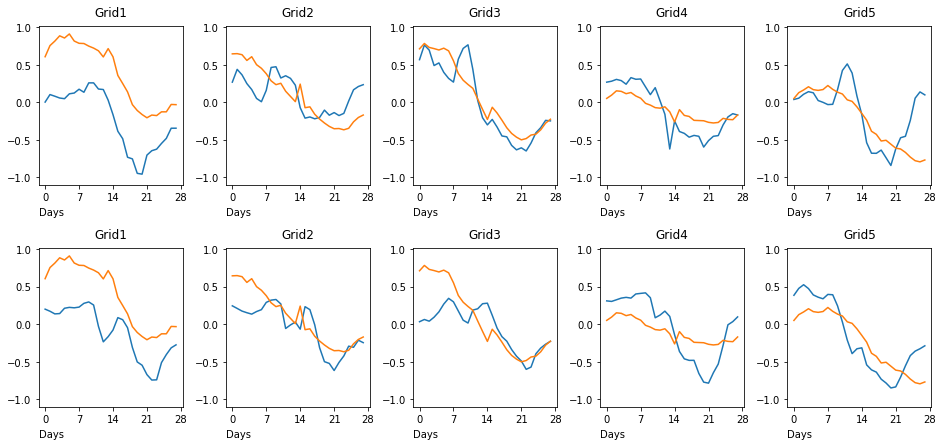

In [47]:
compare_predictions(gru_model, gru_vid_model, X1_test, y1_test)

In [39]:
predictions = gru_vid_model.predict(X1_test).flatten()
surface_type[4,2] = 1
surface_type2 = surface_type*1.6

mapped_preds = np.empty(28, dtype = object)
    
for i in range(28):
    mapped_preds[i] = surface_type2.flatten()
    mapped_preds[i] = mapped_preds[i].astype('float')
    for j in range(187):
        mapped_preds[i][np.where(surface_type2.flatten()==0)[0][j]] = predictions[i*187:(i+1)*187][j]

mapped_y_test = np.empty(28, dtype = object)
for i in range(28):
    mapped_y_test[i] = surface_type2.flatten()
    mapped_y_test[i] = mapped_y_test[i].astype('float')
    for j in range(187):
        mapped_y_test[i][np.where(surface_type2.flatten()==0)[0][j]] = y1_test[i,j]

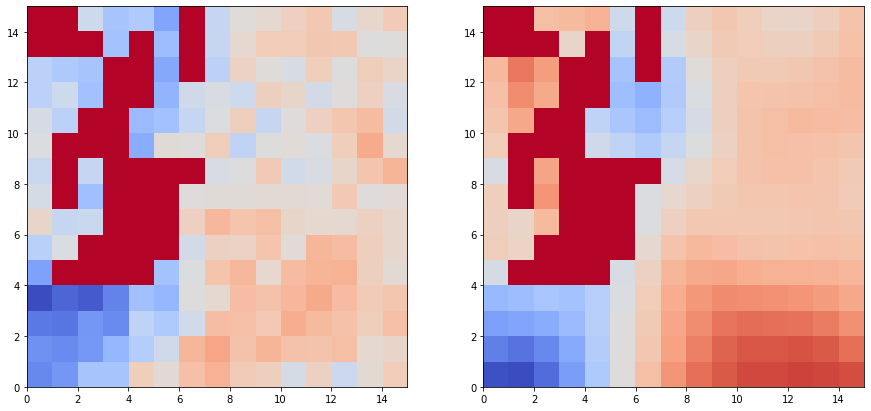

In [40]:
import matplotlib.cm as cm

grids = np.empty(28, dtype = object)
for i in range(28):
    grids[i] = mapped_preds[i].reshape((s, s))

y_grid = np.empty(28, dtype = object)
for i in range(28):
    y_grid[i] = mapped_y_test[i].reshape((s, s))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(grids[0], extent=(0, 15, 0, 15),
           interpolation='nearest', cmap=cm.coolwarm)
ax2.imshow(y_grid[0], extent=(0, 15, 0, 15),
           interpolation='nearest', cmap=cm.coolwarm)


........

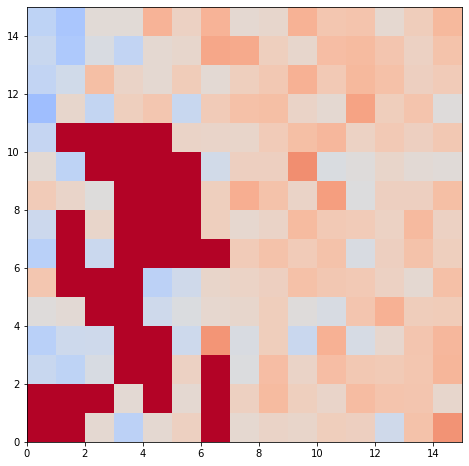

In [41]:
import matplotlib.animation as animation

fps = 5
nSeconds = 6.4
grids_r = np.empty(len(grids), dtype=object)
for i in range(len(grids_r)):
    grids_r[i]= np.flip(grids[i], 0)
snapshots = grids_r.tolist() + 4*grids_r.tolist()[-1:] 

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[0]
#im = plt.imshow(a, interpolation='nearest', aspect='auto', vmin=0, vmax=1, cmap=cm.Blues)
im = plt.imshow(a, extent=(0, 15, 0, 15), interpolation='nearest', vmin=-1.82, vmax=1.6, cmap=cm.coolwarm)#RdYlBu_r)#ocean)#Blues)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

........

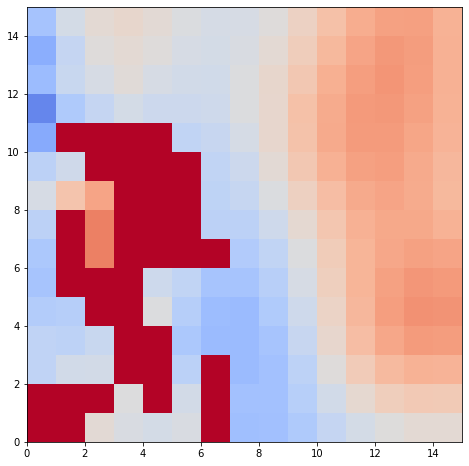

In [42]:
fps = 5
nSeconds = 6.4
y_grid_r = np.empty(len(y_grid), dtype=object)
for i in range(len(y_grid_r)):
    y_grid_r[i]= np.flip(y_grid[i], 0)
snapshots = y_grid_r.tolist()  + 4*y_grid_r.tolist()[-1:] 

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[0]
#im = plt.imshow(a, interpolation='nearest', aspect='auto', vmin=0, vmax=1, cmap=cm.Blues)
im = plt.imshow(a, extent=(0, 15, 0, 15), interpolation='nearest', vmin=-1.82, vmax=1.6, cmap=cm.coolwarm)#RdYlBu_r)#ocean)#Blues)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps, # in ms
                               )

anim.save('y_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

In [43]:
from ipywidgets import Output, GridspecLayout, Video
from IPython import display

filepaths = ['C:/Users/Gil Senecaut/Desktop/UC3M/TFM/Scripts/test_anim.mp4','C:/Users/Gil Senecaut/Desktop/UC3M/TFM/Scripts/y_anim.mp4']

gsl = GridspecLayout(1, len(filepaths))

for i, filepath in enumerate(filepaths):
    video = Video.from_file(filepath, embed=True, width=500, height=500)
    gsl[0, i] = video

gsl

GridspecLayout(children=(Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08fr…